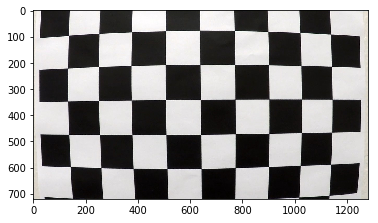

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

img = mpimg.imread('camera_cal/calibration1.jpg')
plt.imshow(img)

In [2]:
def calibrate_camera ():
    objpoints = []
    imgpoints = []

    for fname in images:
        img = cv2.imread(fname)
    # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        nx = 9#TODO: enter the number of inside corners in x
        ny = 6#TODO: enter the number of inside corners in y
    # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
        if ret == True:
            objp = np.zeros((6*9,3), np.float32)
            objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
            objpoints.append(objp)
            imgpoints.append(corners)
            
    # now calibrate your camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    return mtx, dist

In [3]:
THRESH_MIN = 20
THRESH_MAX = 100

def get_sobel(image):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= THRESH_MIN) & (scaled_sobel <= THRESH_MAX)] = 1
    return sxbinary

In [4]:
def mask_image(image):
    sw_x = image.shape[1] * .01
    sw_y = image.shape[0]
    nw_x = int(image.shape[1] * .35)
    nw_y = int(image.shape[0] * .65)
    ne_x = int(image.shape[1] * .65)
    ne_y = int(image.shape[0] * .65)
    se_x = int(image.shape[1] + (image.shape[1] * .1))
    se_y = int(image.shape[0])


    vertices = np.array([[(sw_x, sw_y),
                          (nw_x,nw_y),
                          (ne_x,ne_y),
                          (se_x,se_y)]], dtype=np.int32)



    mask = np.zeros_like(image)
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

In [5]:
BIN_256 = 256
HIST_RANGE_MIN = 0
HIST_RANGE_MAX = 256
MASKED_ARRAY_MIN = 0
MASKED_ARRAY_MAX = 255

def increase_contrast(image):

    equ = cv2.equalizeHist(image)
    hist, bins = np.histogram(equ.flatten(), BIN_256, [HIST_RANGE_MIN, HIST_RANGE_MAX])
    cdf = hist.cumsum()
    cdf_m = np.ma.masked_equal(cdf, MASKED_ARRAY_MIN)
    cdf_m = (cdf_m - cdf_m.min()) * MASKED_ARRAY_MAX / (cdf_m.max() - cdf_m.min())
    cdf = np.ma.filled(cdf_m, MASKED_ARRAY_MIN).astype('uint8')
    histogram = cdf[image]
    return cv2.equalizeHist(histogram)

In [6]:
def get_threshold(image):
    hls = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = increase_contrast(gray)
    s = hls[:, :, 2]
    x, gray_threshold = cv2.threshold(gray.astype('uint8'), 75, 255, cv2.THRESH_BINARY)
    x, s_threshold = cv2.threshold(s.astype('uint8'), 75, 255, cv2.THRESH_BINARY)
    combined_binary = np.clip(cv2.bitwise_and(gray_threshold, s_threshold), 0, 1).astype('uint8')
    return combined_binary

In [7]:
def source():
    src = np.float32([
        [475,530],
        [830,530],
        [130,720],
        [1120,720]
    ])
    return src

def destination():
    src = np.float32([
        [365,540],
        [990,540],
        [320,720],
        [960,720]
    ])
    return src

In [8]:
YM_PER_PX = 30 / 720
XM_PER_PX = 3.7 / 700

#calculate curves
def calculate_curves(leftx,lefty,rightx,righty):
    left_fit_cr = np.polyfit(lefty * YM_PER_PX, leftx * XM_PER_PX, 2)
    right_fit_cr = np.polyfit(righty * YM_PER_PX, rightx * XM_PER_PX, 2)

    left_curverad = ((1 + (2 * left_fit_cr[0] * np.max(lefty) + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * np.max(lefty) + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
    return left_curverad,right_curverad

def get_center_calc(video,left_fitx,right_fitx):
    vehicle_position = video.shape[1] / 2
    center_of_lane = (left_fitx[-1] + right_fitx[-1]) // 2
    center_calc = (vehicle_position - center_of_lane) * XM_PER_PX
    return center_calc

In [9]:
class Lanes:
    cached_result = None
    cached_lane = None
    last_good_right_curve = None
    last_good_left_curve = None

In [10]:
def pipeline(video):
    print('processing')
    masked = mask_image(video)
    undistorted_dash = cv2.undistort(masked, cam_mtx, cam_dist, None, cam_mtx)
    m = cv2.getPerspectiveTransform(source(), destination())
    m_inverse = cv2.getPerspectiveTransform(destination(),source())
    image_size = (undistorted_dash.shape[1],undistorted_dash.shape[0])
    warped = cv2.warpPerspective(undistorted_dash, m, image_size, flags=cv2.INTER_LINEAR)
    threshold = get_threshold(warped)

    histogram = np.sum(threshold[threshold.shape[0]//2:,:], axis=0)
    out_img = np.dstack((threshold, threshold, threshold))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    window_height = np.int(threshold.shape[0]/nwindows)
    nonzero = threshold.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = threshold.shape[0] - (window+1)*window_height
        win_y_high = threshold.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

# this try catch culls out bad frames
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Fit a second order polynomial to each
        Lanes.last_good_right = right_fit
    except:
        return Lanes.cached_result

    ploty = np.linspace(0, threshold.shape[0]-1, threshold.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #
    # out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    # out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    ####
    # calculate curves and centerline
    left_curverad, right_curverad =  calculate_curves(leftx, lefty, rightx, righty)
    center_calc = get_center_calc(video,left_fitx,right_fitx)

    ###
    warp_zero = np.zeros_like(threshold).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # this is a hamfisted solution to replace curves with extreme values with the previous frame's curve
    if (right_curverad > 5000 or left_curverad > 5000) and Lanes.cached_lane is not None:
        newwarp = Lanes.cached_lane
    else:
        newwarp = cv2.warpPerspective(color_warp, m_inverse, (video.shape[1], video.shape[0]))
        Lanes.cached_lane = newwarp
        Lanes.last_good_right_curve = right_curverad
        Lanes.last_good_left_curve = left_curverad

    result = cv2.addWeighted(video, 1, newwarp, 0.3, 0)
    Lanes.cached_result = result

    text = 'curvature radius: {0} m. '.format((int(left_curverad) + int(right_curverad)) / 2 )
    text2 = 'distance from center: {0} m. '.format(( np.math.ceil(abs(center_calc) * 100) / 100))
    cv2.putText(result,text,(25,75),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,0),2,cv2.LINE_AA)
    cv2.putText(result, text2, (25, 120), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 0), 2, cv2.LINE_AA)

    return result

In [11]:
import glob

images = glob.glob('camera_cal/calibration*.jpg')
#calibrate Camera
cam_mtx, cam_dist = calibrate_camera()

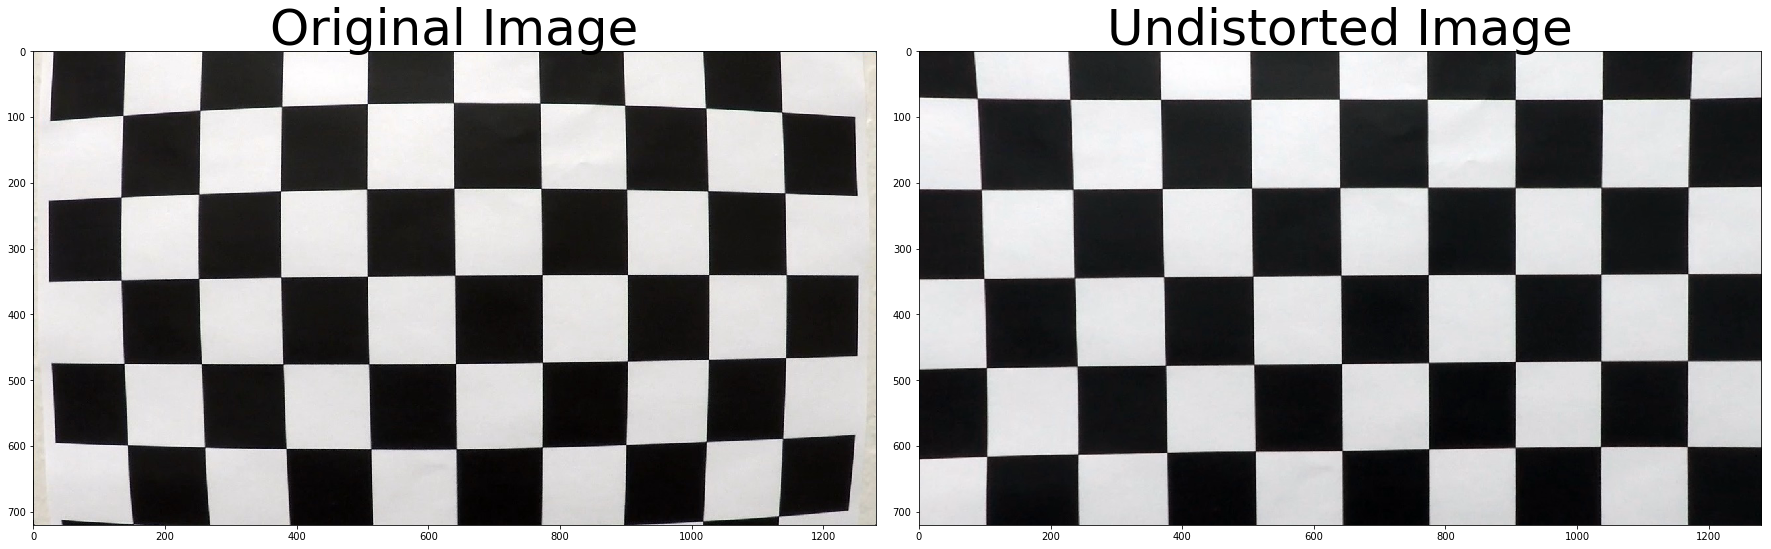

In [12]:
image = cv2.imread('camera_cal/calibration1.jpg')
undist = cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)
#
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

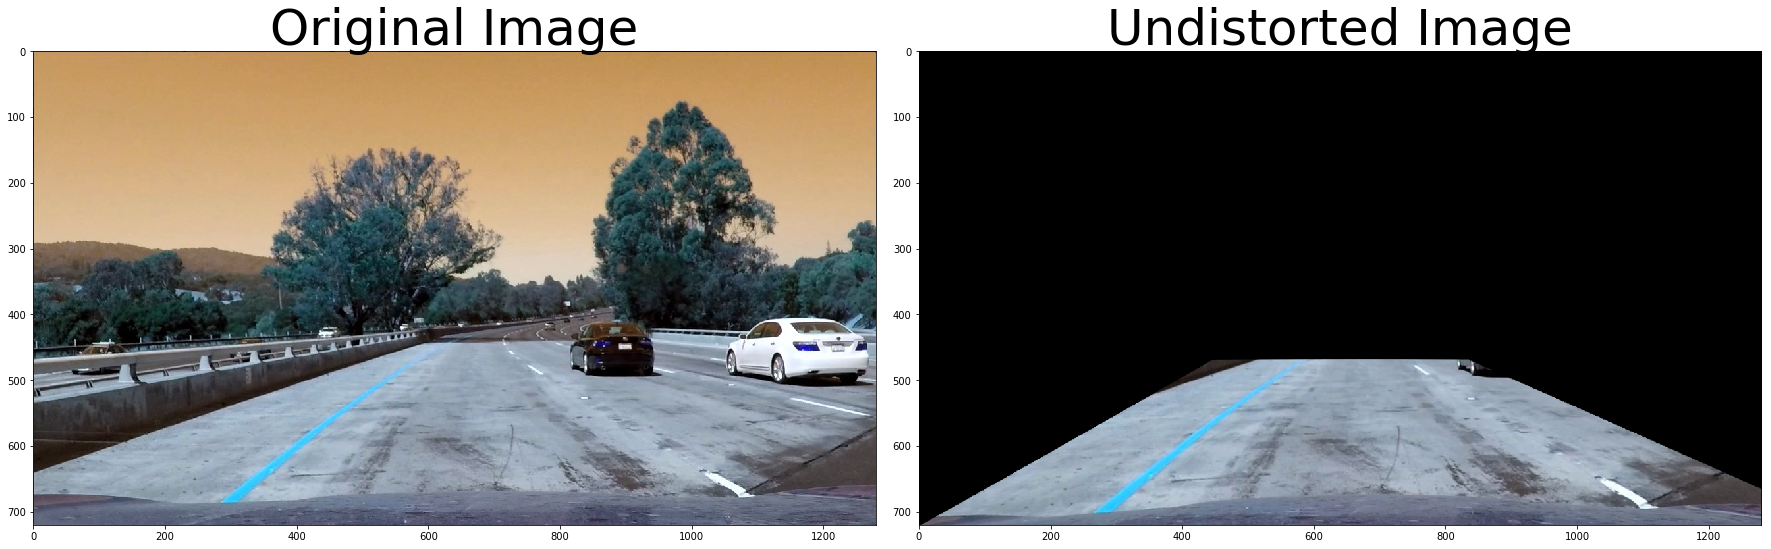

In [13]:
image = cv2.imread('test_images/test1.jpg')
masked = mask_image(image)
undistorted_dash = cv2.undistort(masked, cam_mtx, cam_dist, None, cam_mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image,cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_dash)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

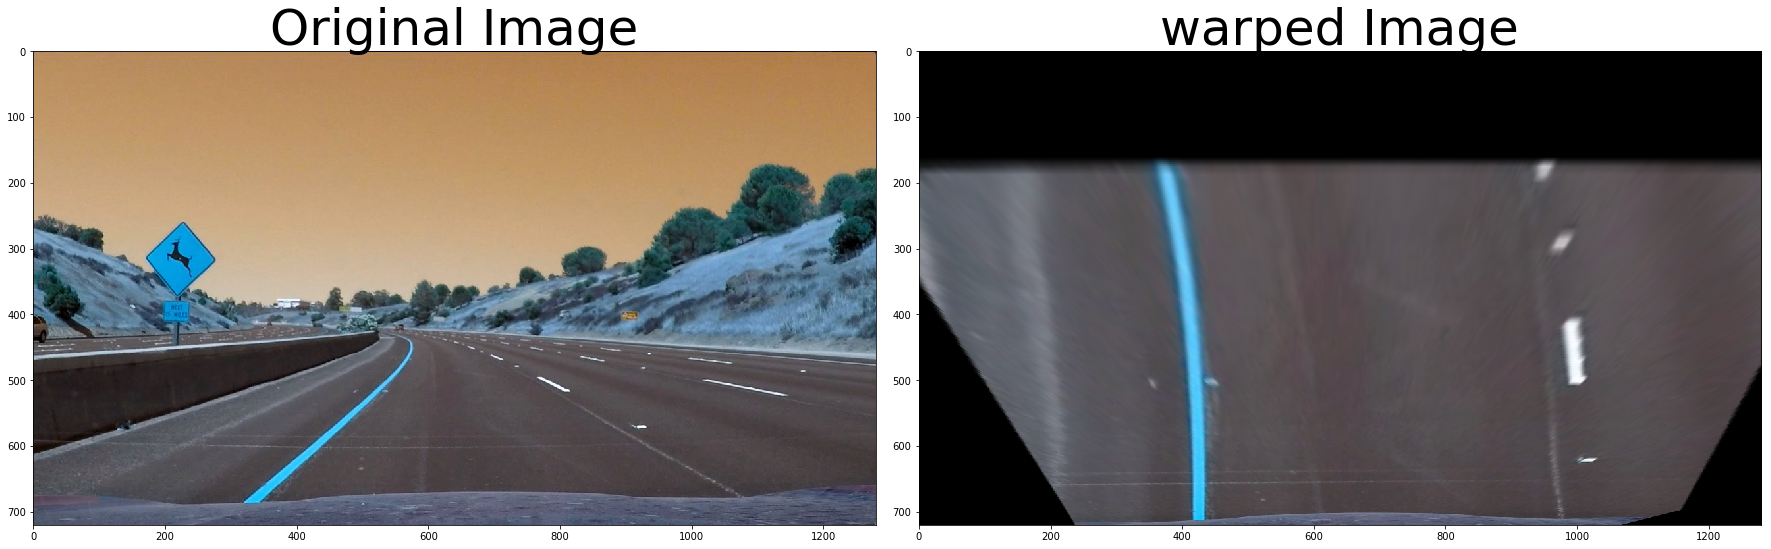

In [14]:
image = cv2.imread('test_images/test2.jpg')
masked = mask_image(image)
undistorted_dash = cv2.undistort(masked, cam_mtx, cam_dist, None, cam_mtx)
m = cv2.getPerspectiveTransform(source(), destination())
m_inverse = cv2.getPerspectiveTransform(destination(), source())
image_size = (undistorted_dash.shape[1], undistorted_dash.shape[0])
warped = cv2.warpPerspective(undistorted_dash, m, image_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

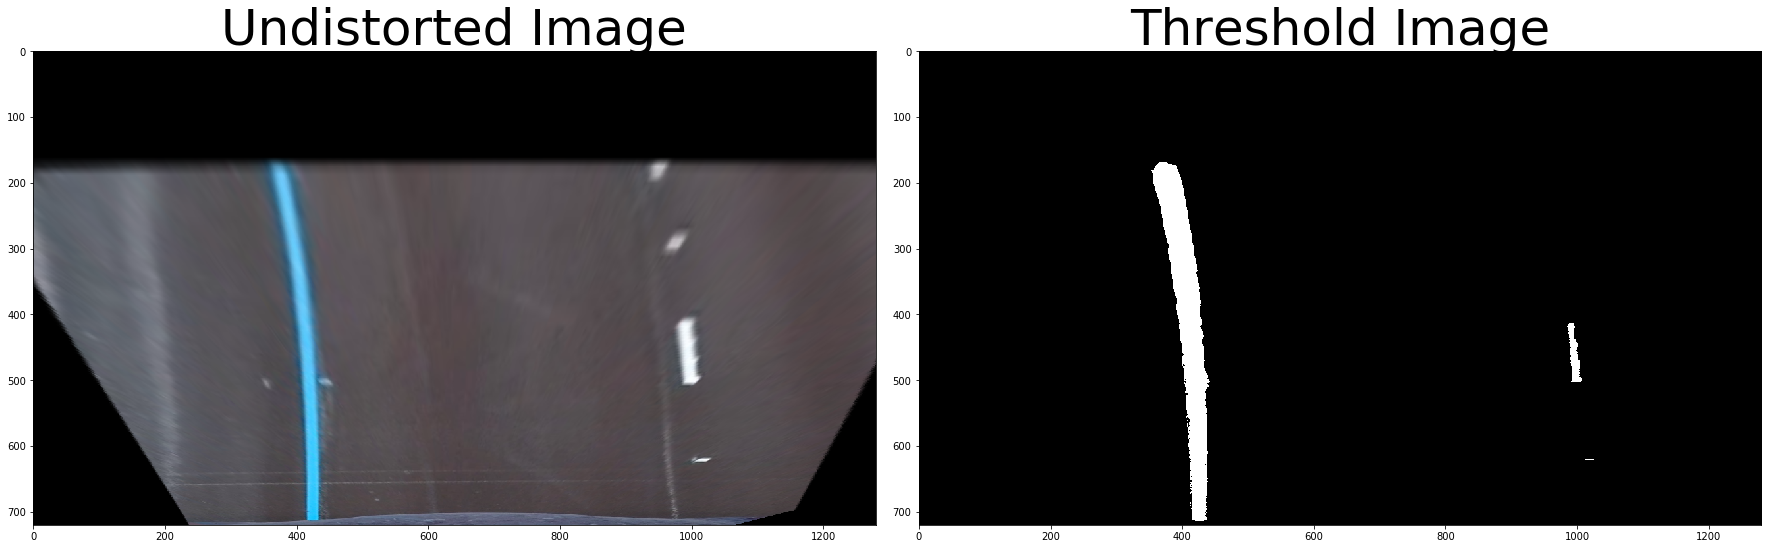

In [15]:
image = cv2.imread('test_images/test2.jpg')
masked = mask_image(image)
undistorted_dash = cv2.undistort(masked, cam_mtx, cam_dist, None, cam_mtx)
m = cv2.getPerspectiveTransform(source(), destination())
m_inverse = cv2.getPerspectiveTransform(destination(), source())
image_size = (undistorted_dash.shape[1], undistorted_dash.shape[0])
warped = cv2.warpPerspective(undistorted_dash, m, image_size, flags=cv2.INTER_LINEAR)
threshold = get_threshold(warped)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(threshold,cmap='gray')
ax2.set_title('Threshold Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

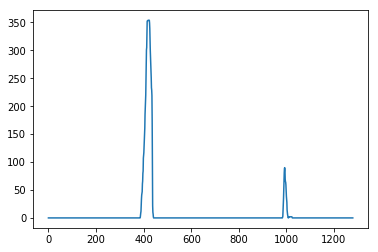

In [16]:
image = cv2.imread('test_images/test2.jpg')
masked = mask_image(image)
undistorted_dash = cv2.undistort(masked, cam_mtx, cam_dist, None, cam_mtx)
m = cv2.getPerspectiveTransform(source(), destination())
m_inverse = cv2.getPerspectiveTransform(destination(), source())
image_size = (undistorted_dash.shape[1], undistorted_dash.shape[0])
warped = cv2.warpPerspective(undistorted_dash, m, image_size, flags=cv2.INTER_LINEAR)
threshold = get_threshold(warped)
histogram = np.sum(threshold[threshold.shape[0] // 2:, :], axis=0)
out_img = np.dstack((threshold, threshold, threshold)) * 255
#
plt.plot(histogram)
plt.show(block=True)

(720, 0)

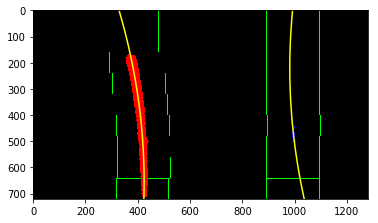

In [17]:

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
nwindows = 9
window_height = np.int(threshold.shape[0]/nwindows)
nonzero = threshold.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
leftx_current = leftx_base
rightx_current = rightx_base
margin = 100
minpix = 50
left_lane_inds = []
right_lane_inds = []

for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
    win_y_low = threshold.shape[0] - (window+1)*window_height
    win_y_high = threshold.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, threshold.shape[0]-1, threshold.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

processing


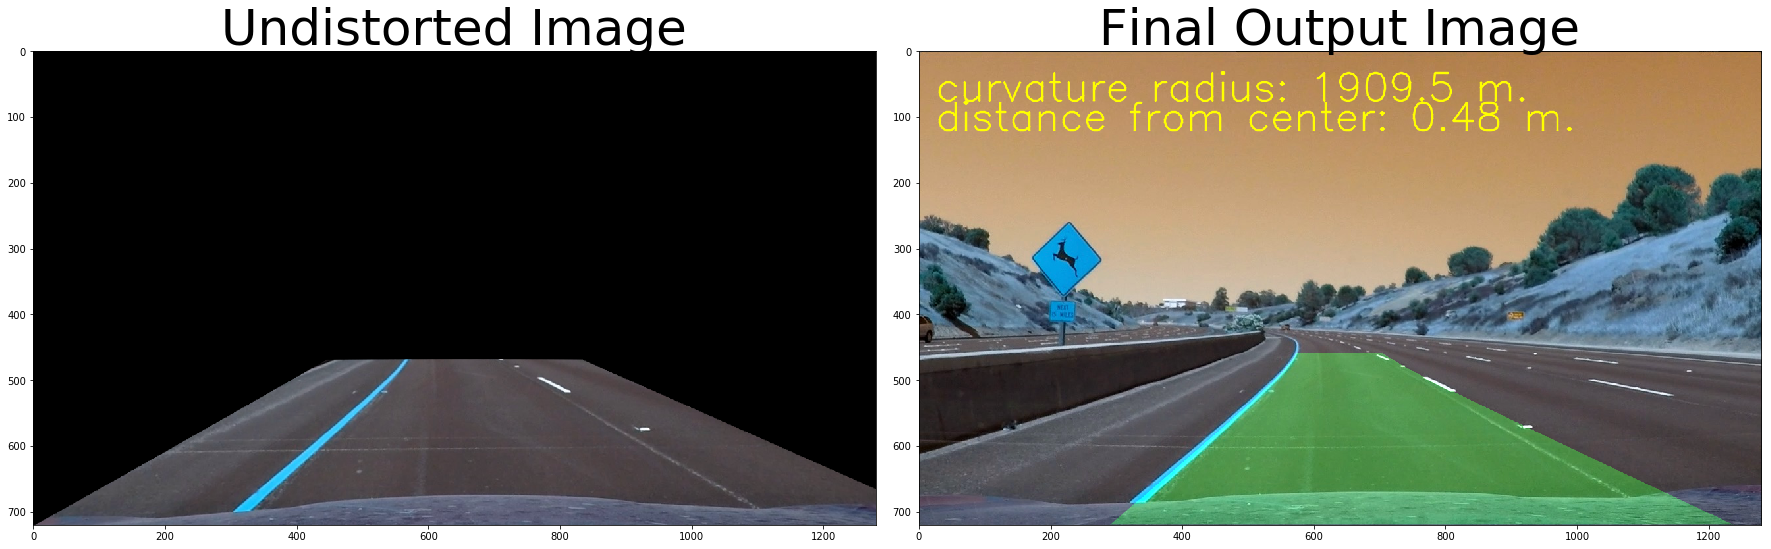

In [18]:
image = cv2.imread('test_images/test2.jpg')
result = pipeline(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted_dash)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(result)
ax2.set_title('Final Output Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [19]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

write_output = 'output_videos/project_video_out6.mp4'
clip1 = VideoFileClip("project_video.mp4")
write_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)

processing
[MoviePy] >>>> Building video output_videos/project_video_out6.mp4
[MoviePy] Writing video output_videos/project_video_out6.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

processing


  0%|          | 1/1261 [00:00<02:24,  8.69it/s]

processing


  0%|          | 2/1261 [00:00<02:31,  8.32it/s]

processing


  0%|          | 3/1261 [00:00<02:29,  8.39it/s]

processing


  0%|          | 4/1261 [00:00<02:29,  8.42it/s]

processing


  0%|          | 5/1261 [00:00<02:28,  8.44it/s]

processing


  0%|          | 6/1261 [00:00<02:28,  8.46it/s]

processing


  1%|          | 7/1261 [00:00<02:27,  8.49it/s]

processing


  1%|          | 8/1261 [00:00<02:24,  8.69it/s]

processing


  1%|          | 9/1261 [00:01<02:25,  8.60it/s]

processing


  1%|          | 10/1261 [00:01<02:24,  8.69it/s]

processing


  1%|          | 11/1261 [00:01<02:25,  8.61it/s]

processing


  1%|          | 12/1261 [00:01<02:24,  8.65it/s]

processing


  1%|          | 13/1261 [00:01<02:24,  8.66it/s]

processing


  1%|          | 14/1261 [00:01<02:24,  8.63it/s]

processing


  1%|          | 15/1261 [00:01<02:24,  8.64it/s]

processing


  1%|▏         | 16/1261 [00:01<02:23,  8.68it/s]

processing


  1%|▏         | 17/1261 [00:01<02:23,  8.66it/s]

processing


  1%|▏         | 18/1261 [00:02<02:22,  8.70it/s]

processing


  2%|▏         | 19/1261 [00:02<02:23,  8.65it/s]

processing


  2%|▏         | 20/1261 [00:02<02:23,  8.66it/s]

processing


  2%|▏         | 21/1261 [00:02<02:23,  8.66it/s]

processing


  2%|▏         | 22/1261 [00:02<02:24,  8.57it/s]

processing


  2%|▏         | 23/1261 [00:02<02:23,  8.62it/s]

processing


  2%|▏         | 24/1261 [00:02<02:22,  8.70it/s]

processing


  2%|▏         | 25/1261 [00:02<02:22,  8.70it/s]

processing


  2%|▏         | 26/1261 [00:03<02:21,  8.73it/s]

processing


  2%|▏         | 27/1261 [00:03<02:22,  8.65it/s]

processing


  2%|▏         | 28/1261 [00:03<02:21,  8.71it/s]

processing


  2%|▏         | 29/1261 [00:03<02:23,  8.59it/s]

processing


  2%|▏         | 30/1261 [00:03<02:24,  8.49it/s]

processing


  2%|▏         | 31/1261 [00:03<02:23,  8.57it/s]

processing


  3%|▎         | 32/1261 [00:03<02:22,  8.60it/s]

processing


  3%|▎         | 33/1261 [00:03<02:23,  8.57it/s]

processing


  3%|▎         | 34/1261 [00:03<02:23,  8.53it/s]

processing


  3%|▎         | 35/1261 [00:04<02:23,  8.53it/s]

processing


  3%|▎         | 36/1261 [00:04<02:21,  8.63it/s]

processing


  3%|▎         | 37/1261 [00:04<02:21,  8.64it/s]

processing


  3%|▎         | 38/1261 [00:04<02:22,  8.58it/s]

processing


  3%|▎         | 39/1261 [00:04<02:20,  8.67it/s]

processing


  3%|▎         | 40/1261 [00:04<02:20,  8.68it/s]

processing


  3%|▎         | 41/1261 [00:04<02:20,  8.70it/s]

processing


  3%|▎         | 42/1261 [00:04<02:19,  8.72it/s]

processing


  3%|▎         | 43/1261 [00:04<02:19,  8.73it/s]

processing


  3%|▎         | 44/1261 [00:05<02:19,  8.75it/s]

processing


  4%|▎         | 45/1261 [00:05<02:18,  8.78it/s]

processing


  4%|▎         | 46/1261 [00:05<02:15,  8.97it/s]

processing


  4%|▎         | 47/1261 [00:05<02:17,  8.86it/s]

processing


  4%|▍         | 48/1261 [00:05<02:16,  8.87it/s]

processing


  4%|▍         | 49/1261 [00:05<02:16,  8.86it/s]

processing


  4%|▍         | 50/1261 [00:05<02:16,  8.89it/s]

processing


  4%|▍         | 51/1261 [00:05<02:15,  8.90it/s]

processing


  4%|▍         | 52/1261 [00:06<02:15,  8.95it/s]

processing


  4%|▍         | 53/1261 [00:06<02:13,  9.06it/s]

processing


  4%|▍         | 54/1261 [00:06<02:12,  9.14it/s]

processing


  4%|▍         | 55/1261 [00:06<02:10,  9.26it/s]

processing


  4%|▍         | 56/1261 [00:06<02:08,  9.34it/s]

processing


  5%|▍         | 57/1261 [00:06<02:08,  9.40it/s]

processing


  5%|▍         | 58/1261 [00:06<02:10,  9.18it/s]

processing


  5%|▍         | 59/1261 [00:06<02:08,  9.36it/s]

processing


  5%|▍         | 60/1261 [00:06<02:06,  9.46it/s]

processing


  5%|▍         | 61/1261 [00:06<02:07,  9.43it/s]

processing


  5%|▍         | 62/1261 [00:07<02:07,  9.39it/s]

processing


  5%|▍         | 63/1261 [00:07<02:07,  9.41it/s]

processing


  5%|▌         | 64/1261 [00:07<02:06,  9.44it/s]

processing


  5%|▌         | 65/1261 [00:07<02:06,  9.47it/s]

processing


  5%|▌         | 66/1261 [00:07<02:06,  9.47it/s]

processing


  5%|▌         | 67/1261 [00:07<02:05,  9.51it/s]

processing


  5%|▌         | 68/1261 [00:07<02:06,  9.44it/s]

processing


  5%|▌         | 69/1261 [00:07<02:06,  9.42it/s]

processing


  6%|▌         | 70/1261 [00:07<02:07,  9.33it/s]

processing


  6%|▌         | 72/1261 [00:08<02:04,  9.55it/s]

processing
processing


  6%|▌         | 73/1261 [00:08<02:04,  9.52it/s]

processing


  6%|▌         | 74/1261 [00:08<02:05,  9.50it/s]

processing


  6%|▌         | 75/1261 [00:08<02:04,  9.50it/s]

processing


  6%|▌         | 76/1261 [00:08<02:05,  9.42it/s]

processing


  6%|▌         | 77/1261 [00:08<02:07,  9.29it/s]

processing


  6%|▌         | 78/1261 [00:08<02:09,  9.16it/s]

processing


  6%|▋         | 79/1261 [00:08<02:10,  9.06it/s]

processing


  6%|▋         | 80/1261 [00:08<02:10,  9.02it/s]

processing


  6%|▋         | 81/1261 [00:09<02:11,  8.98it/s]

processing


  7%|▋         | 82/1261 [00:09<02:11,  8.99it/s]

processing


  7%|▋         | 83/1261 [00:09<02:11,  8.98it/s]

processing


  7%|▋         | 84/1261 [00:09<02:08,  9.13it/s]

processing


  7%|▋         | 85/1261 [00:09<02:10,  9.00it/s]

processing


  7%|▋         | 86/1261 [00:09<02:07,  9.20it/s]

processing


  7%|▋         | 87/1261 [00:09<02:08,  9.17it/s]

processing


  7%|▋         | 88/1261 [00:09<02:08,  9.13it/s]

processing


  7%|▋         | 89/1261 [00:09<02:08,  9.09it/s]

processing


  7%|▋         | 90/1261 [00:10<02:08,  9.10it/s]

processing


  7%|▋         | 91/1261 [00:10<02:08,  9.10it/s]

processing


  7%|▋         | 92/1261 [00:10<02:07,  9.18it/s]

processing


  7%|▋         | 93/1261 [00:10<02:06,  9.20it/s]

processing


  7%|▋         | 94/1261 [00:10<02:06,  9.20it/s]

processing


  8%|▊         | 95/1261 [00:10<02:05,  9.26it/s]

processing


  8%|▊         | 96/1261 [00:10<02:06,  9.21it/s]

processing


  8%|▊         | 97/1261 [00:10<02:06,  9.20it/s]

processing


  8%|▊         | 98/1261 [00:10<02:07,  9.10it/s]

processing


  8%|▊         | 99/1261 [00:11<02:07,  9.08it/s]

processing


  8%|▊         | 100/1261 [00:11<02:08,  9.07it/s]

processing


  8%|▊         | 101/1261 [00:11<02:07,  9.11it/s]

processing


  8%|▊         | 102/1261 [00:11<02:08,  9.01it/s]

processing


  8%|▊         | 103/1261 [00:11<02:07,  9.09it/s]

processing


  8%|▊         | 104/1261 [00:11<02:05,  9.20it/s]

processing


  8%|▊         | 105/1261 [00:11<02:05,  9.19it/s]

processing


  8%|▊         | 106/1261 [00:11<02:07,  9.04it/s]

processing


  8%|▊         | 107/1261 [00:11<02:07,  9.07it/s]

processing


  9%|▊         | 108/1261 [00:12<02:06,  9.13it/s]

processing


  9%|▊         | 109/1261 [00:12<02:08,  8.99it/s]

processing


  9%|▊         | 110/1261 [00:12<02:08,  8.99it/s]

processing


  9%|▉         | 111/1261 [00:12<02:07,  9.01it/s]

processing


  9%|▉         | 112/1261 [00:12<02:05,  9.12it/s]

processing


  9%|▉         | 113/1261 [00:12<02:05,  9.16it/s]

processing


  9%|▉         | 114/1261 [00:12<02:04,  9.21it/s]

processing


  9%|▉         | 115/1261 [00:12<02:05,  9.11it/s]

processing


  9%|▉         | 116/1261 [00:12<02:05,  9.09it/s]

processing


  9%|▉         | 117/1261 [00:13<02:04,  9.17it/s]

processing


  9%|▉         | 118/1261 [00:13<02:05,  9.08it/s]

processing


  9%|▉         | 119/1261 [00:13<02:06,  9.05it/s]

processing


 10%|▉         | 120/1261 [00:13<02:05,  9.08it/s]

processing


 10%|▉         | 121/1261 [00:13<02:04,  9.18it/s]

processing


 10%|▉         | 122/1261 [00:13<02:03,  9.24it/s]

processing


 10%|▉         | 123/1261 [00:13<02:03,  9.25it/s]

processing


 10%|▉         | 124/1261 [00:13<02:05,  9.08it/s]

processing


 10%|▉         | 125/1261 [00:13<02:05,  9.08it/s]

processing


 10%|▉         | 126/1261 [00:14<02:04,  9.08it/s]

processing


 10%|█         | 127/1261 [00:14<02:03,  9.18it/s]

processing


 10%|█         | 128/1261 [00:14<02:03,  9.19it/s]

processing


 10%|█         | 129/1261 [00:14<02:06,  8.96it/s]

processing


 10%|█         | 130/1261 [00:14<02:05,  8.99it/s]

processing


 10%|█         | 131/1261 [00:14<02:05,  8.98it/s]

processing


 10%|█         | 132/1261 [00:14<02:05,  8.98it/s]

processing


 11%|█         | 133/1261 [00:14<02:05,  9.01it/s]

processing


 11%|█         | 134/1261 [00:14<02:05,  9.00it/s]

processing


 11%|█         | 135/1261 [00:15<02:05,  8.99it/s]

processing


 11%|█         | 136/1261 [00:15<02:06,  8.93it/s]

processing


 11%|█         | 137/1261 [00:15<02:05,  8.97it/s]

processing


 11%|█         | 138/1261 [00:15<02:03,  9.07it/s]

processing


 11%|█         | 139/1261 [00:15<02:03,  9.08it/s]

processing


 11%|█         | 140/1261 [00:15<02:02,  9.16it/s]

processing


 11%|█         | 141/1261 [00:15<02:04,  9.01it/s]

processing


 11%|█▏        | 142/1261 [00:15<02:04,  8.96it/s]

processing


 11%|█▏        | 143/1261 [00:15<02:05,  8.90it/s]

processing


 11%|█▏        | 144/1261 [00:16<02:04,  8.94it/s]

processing


 11%|█▏        | 145/1261 [00:16<02:05,  8.91it/s]

processing


 12%|█▏        | 146/1261 [00:16<02:05,  8.87it/s]

processing


 12%|█▏        | 147/1261 [00:16<02:04,  8.93it/s]

processing


 12%|█▏        | 148/1261 [00:16<02:03,  9.00it/s]

processing


 12%|█▏        | 149/1261 [00:16<02:04,  8.92it/s]

processing


 12%|█▏        | 150/1261 [00:16<02:04,  8.95it/s]

processing


 12%|█▏        | 151/1261 [00:16<02:03,  8.99it/s]

processing


 12%|█▏        | 152/1261 [00:16<02:02,  9.02it/s]

processing


 12%|█▏        | 153/1261 [00:17<02:02,  9.01it/s]

processing


 12%|█▏        | 154/1261 [00:17<02:04,  8.88it/s]

processing


 12%|█▏        | 155/1261 [00:17<02:05,  8.81it/s]

processing


 12%|█▏        | 156/1261 [00:17<02:05,  8.84it/s]

processing


 12%|█▏        | 157/1261 [00:17<02:04,  8.87it/s]

processing


 13%|█▎        | 158/1261 [00:17<02:03,  8.96it/s]

processing


 13%|█▎        | 159/1261 [00:17<02:03,  8.93it/s]

processing


 13%|█▎        | 160/1261 [00:17<02:03,  8.93it/s]

processing


 13%|█▎        | 161/1261 [00:17<02:02,  9.01it/s]

processing


 13%|█▎        | 162/1261 [00:18<02:02,  8.99it/s]

processing


 13%|█▎        | 163/1261 [00:18<02:02,  8.93it/s]

processing


 13%|█▎        | 164/1261 [00:18<02:01,  8.99it/s]

processing


 13%|█▎        | 165/1261 [00:18<02:02,  8.95it/s]

processing


 13%|█▎        | 166/1261 [00:18<02:02,  8.95it/s]

processing


 13%|█▎        | 167/1261 [00:18<02:01,  9.04it/s]

processing


 13%|█▎        | 168/1261 [00:18<02:00,  9.07it/s]

processing


 13%|█▎        | 169/1261 [00:18<01:59,  9.13it/s]

processing


 13%|█▎        | 170/1261 [00:18<02:01,  8.95it/s]

processing


 14%|█▎        | 171/1261 [00:19<02:02,  8.92it/s]

processing


 14%|█▎        | 172/1261 [00:19<02:03,  8.81it/s]

processing


 14%|█▎        | 173/1261 [00:19<02:03,  8.83it/s]

processing


 14%|█▍        | 174/1261 [00:19<02:03,  8.80it/s]

processing


 14%|█▍        | 175/1261 [00:19<02:03,  8.82it/s]

processing


 14%|█▍        | 176/1261 [00:19<02:01,  8.90it/s]

processing


 14%|█▍        | 177/1261 [00:19<02:02,  8.88it/s]

processing


 14%|█▍        | 178/1261 [00:19<02:03,  8.74it/s]

processing


 14%|█▍        | 179/1261 [00:19<02:02,  8.82it/s]

processing


 14%|█▍        | 180/1261 [00:20<02:00,  8.94it/s]

processing


 14%|█▍        | 181/1261 [00:20<02:01,  8.92it/s]

processing


 14%|█▍        | 182/1261 [00:20<01:59,  9.03it/s]

processing


 15%|█▍        | 183/1261 [00:20<01:58,  9.08it/s]

processing


 15%|█▍        | 184/1261 [00:20<01:58,  9.08it/s]

processing


 15%|█▍        | 185/1261 [00:20<01:58,  9.05it/s]

processing


 15%|█▍        | 186/1261 [00:20<01:57,  9.11it/s]

processing


 15%|█▍        | 187/1261 [00:20<01:56,  9.19it/s]

processing


 15%|█▍        | 188/1261 [00:20<01:56,  9.21it/s]

processing


 15%|█▍        | 189/1261 [00:21<01:56,  9.23it/s]

processing


 15%|█▌        | 190/1261 [00:21<01:56,  9.16it/s]

processing


 15%|█▌        | 191/1261 [00:21<01:58,  9.03it/s]

processing


 15%|█▌        | 192/1261 [00:21<01:59,  8.98it/s]

processing


 15%|█▌        | 193/1261 [00:21<01:59,  8.96it/s]

processing


 15%|█▌        | 194/1261 [00:21<01:58,  8.98it/s]

processing


 15%|█▌        | 195/1261 [00:21<01:58,  8.99it/s]

processing


 16%|█▌        | 196/1261 [00:21<01:59,  8.91it/s]

processing


 16%|█▌        | 197/1261 [00:21<02:00,  8.83it/s]

processing


 16%|█▌        | 198/1261 [00:22<02:00,  8.79it/s]

processing


 16%|█▌        | 199/1261 [00:22<02:01,  8.77it/s]

processing


 16%|█▌        | 200/1261 [00:22<02:01,  8.71it/s]

processing


 16%|█▌        | 201/1261 [00:22<02:02,  8.64it/s]

processing


 16%|█▌        | 202/1261 [00:22<02:02,  8.63it/s]

processing


 16%|█▌        | 203/1261 [00:22<02:02,  8.64it/s]

processing


 16%|█▌        | 204/1261 [00:22<02:02,  8.64it/s]

processing


 16%|█▋        | 205/1261 [00:22<01:59,  8.83it/s]

processing


 16%|█▋        | 206/1261 [00:22<01:57,  9.01it/s]

processing


 16%|█▋        | 207/1261 [00:23<01:56,  9.08it/s]

processing


 16%|█▋        | 208/1261 [00:23<01:56,  9.02it/s]

processing


 17%|█▋        | 209/1261 [00:23<01:56,  9.02it/s]

processing


 17%|█▋        | 210/1261 [00:23<01:55,  9.09it/s]

processing


 17%|█▋        | 211/1261 [00:23<01:54,  9.17it/s]

processing


 17%|█▋        | 212/1261 [00:23<01:54,  9.18it/s]

processing


 17%|█▋        | 213/1261 [00:23<01:55,  9.10it/s]

processing


 17%|█▋        | 214/1261 [00:23<01:54,  9.11it/s]

processing


 17%|█▋        | 215/1261 [00:23<01:55,  9.05it/s]

processing


 17%|█▋        | 216/1261 [00:24<01:55,  9.06it/s]

processing


 17%|█▋        | 217/1261 [00:24<01:56,  8.93it/s]

processing


 17%|█▋        | 218/1261 [00:24<01:56,  8.93it/s]

processing


 17%|█▋        | 219/1261 [00:24<01:57,  8.90it/s]

processing


 17%|█▋        | 220/1261 [00:24<01:57,  8.85it/s]

processing


 18%|█▊        | 221/1261 [00:24<01:57,  8.86it/s]

processing


 18%|█▊        | 222/1261 [00:24<01:57,  8.87it/s]

processing


 18%|█▊        | 223/1261 [00:24<01:57,  8.85it/s]

processing


 18%|█▊        | 224/1261 [00:24<01:57,  8.79it/s]

processing


 18%|█▊        | 225/1261 [00:25<01:57,  8.83it/s]

processing


 18%|█▊        | 226/1261 [00:25<01:55,  8.94it/s]

processing


 18%|█▊        | 227/1261 [00:25<01:56,  8.89it/s]

processing


 18%|█▊        | 228/1261 [00:25<01:56,  8.88it/s]

processing


 18%|█▊        | 229/1261 [00:25<01:56,  8.83it/s]

processing


 18%|█▊        | 230/1261 [00:25<01:55,  8.91it/s]

processing


 18%|█▊        | 231/1261 [00:25<01:55,  8.91it/s]

processing


 18%|█▊        | 232/1261 [00:25<01:55,  8.88it/s]

processing


 18%|█▊        | 233/1261 [00:26<01:55,  8.88it/s]

processing


 19%|█▊        | 234/1261 [00:26<01:54,  8.99it/s]

processing


 19%|█▊        | 235/1261 [00:26<01:52,  9.11it/s]

processing


 19%|█▊        | 236/1261 [00:26<01:52,  9.08it/s]

processing


 19%|█▉        | 237/1261 [00:26<01:52,  9.07it/s]

processing


 19%|█▉        | 238/1261 [00:26<01:55,  8.88it/s]

processing


 19%|█▉        | 239/1261 [00:26<01:54,  8.91it/s]

processing


 19%|█▉        | 240/1261 [00:26<01:53,  8.98it/s]

processing


 19%|█▉        | 241/1261 [00:26<01:54,  8.94it/s]

processing


 19%|█▉        | 242/1261 [00:27<01:54,  8.87it/s]

processing


 19%|█▉        | 243/1261 [00:27<01:54,  8.91it/s]

processing


 19%|█▉        | 244/1261 [00:27<01:56,  8.75it/s]

processing


 19%|█▉        | 245/1261 [00:27<01:54,  8.86it/s]

processing


 20%|█▉        | 246/1261 [00:27<01:54,  8.85it/s]

processing


 20%|█▉        | 247/1261 [00:27<01:54,  8.87it/s]

processing


 20%|█▉        | 248/1261 [00:27<01:53,  8.92it/s]

processing


 20%|█▉        | 249/1261 [00:27<01:56,  8.72it/s]

processing


 20%|█▉        | 250/1261 [00:27<01:54,  8.81it/s]

processing


 20%|█▉        | 251/1261 [00:28<01:52,  8.96it/s]

processing


 20%|█▉        | 252/1261 [00:28<01:52,  8.99it/s]

processing


 20%|██        | 253/1261 [00:28<01:52,  8.96it/s]

processing


 20%|██        | 254/1261 [00:28<01:52,  8.97it/s]

processing


 20%|██        | 255/1261 [00:28<01:51,  9.01it/s]

processing


 20%|██        | 256/1261 [00:28<01:51,  8.97it/s]

processing


 20%|██        | 257/1261 [00:28<01:51,  9.01it/s]

processing


 20%|██        | 258/1261 [00:28<01:51,  9.01it/s]

processing


 21%|██        | 259/1261 [00:28<01:52,  8.92it/s]

processing


 21%|██        | 260/1261 [00:29<01:52,  8.91it/s]

processing


 21%|██        | 261/1261 [00:29<01:51,  9.00it/s]

processing


 21%|██        | 262/1261 [00:29<01:50,  9.02it/s]

processing


 21%|██        | 263/1261 [00:29<01:50,  9.00it/s]

processing


 21%|██        | 264/1261 [00:29<01:51,  8.96it/s]

processing


 21%|██        | 265/1261 [00:29<01:51,  8.97it/s]

processing


 21%|██        | 266/1261 [00:29<01:52,  8.88it/s]

processing


 21%|██        | 267/1261 [00:29<01:51,  8.91it/s]

processing


 21%|██▏       | 268/1261 [00:29<01:52,  8.85it/s]

processing


 21%|██▏       | 269/1261 [00:30<01:51,  8.88it/s]

processing


 21%|██▏       | 270/1261 [00:30<01:52,  8.82it/s]

processing


 21%|██▏       | 271/1261 [00:30<01:52,  8.80it/s]

processing


 22%|██▏       | 272/1261 [00:30<01:52,  8.77it/s]

processing


 22%|██▏       | 273/1261 [00:30<01:52,  8.75it/s]

processing


 22%|██▏       | 274/1261 [00:30<01:53,  8.70it/s]

processing


 22%|██▏       | 275/1261 [00:30<01:53,  8.72it/s]

processing


 22%|██▏       | 276/1261 [00:30<01:53,  8.70it/s]

processing


 22%|██▏       | 277/1261 [00:30<01:51,  8.80it/s]

processing


 22%|██▏       | 278/1261 [00:31<01:50,  8.90it/s]

processing


 22%|██▏       | 279/1261 [00:31<01:50,  8.90it/s]

processing


 22%|██▏       | 280/1261 [00:31<01:50,  8.90it/s]

processing


 22%|██▏       | 281/1261 [00:31<01:48,  9.04it/s]

processing


 22%|██▏       | 282/1261 [00:31<01:47,  9.13it/s]

processing


 22%|██▏       | 283/1261 [00:31<01:46,  9.20it/s]

processing


 23%|██▎       | 284/1261 [00:31<01:46,  9.20it/s]

processing


 23%|██▎       | 285/1261 [00:31<01:45,  9.26it/s]

processing


 23%|██▎       | 286/1261 [00:31<01:45,  9.24it/s]

processing


 23%|██▎       | 287/1261 [00:32<01:46,  9.15it/s]

processing


 23%|██▎       | 288/1261 [00:32<01:46,  9.14it/s]

processing


 23%|██▎       | 289/1261 [00:32<01:47,  9.01it/s]

processing


 23%|██▎       | 290/1261 [00:32<01:47,  9.06it/s]

processing


 23%|██▎       | 291/1261 [00:32<01:46,  9.08it/s]

processing


 23%|██▎       | 292/1261 [00:32<01:47,  9.01it/s]

processing


 23%|██▎       | 293/1261 [00:32<01:48,  8.95it/s]

processing


 23%|██▎       | 294/1261 [00:32<01:48,  8.88it/s]

processing


 23%|██▎       | 295/1261 [00:32<01:48,  8.87it/s]

processing


 23%|██▎       | 296/1261 [00:33<01:47,  8.97it/s]

processing


 24%|██▎       | 297/1261 [00:33<01:47,  8.96it/s]

processing


 24%|██▎       | 298/1261 [00:33<01:55,  8.36it/s]

processing


 24%|██▎       | 299/1261 [00:33<01:54,  8.37it/s]

processing


 24%|██▍       | 300/1261 [00:33<01:53,  8.49it/s]

processing


 24%|██▍       | 301/1261 [00:33<01:50,  8.68it/s]

processing


 24%|██▍       | 302/1261 [00:33<01:49,  8.77it/s]

processing


 24%|██▍       | 303/1261 [00:33<01:48,  8.85it/s]

processing


 24%|██▍       | 304/1261 [00:33<01:48,  8.84it/s]

processing


 24%|██▍       | 305/1261 [00:34<01:47,  8.89it/s]

processing


 24%|██▍       | 306/1261 [00:34<01:47,  8.87it/s]

processing


 24%|██▍       | 307/1261 [00:34<01:47,  8.91it/s]

processing


 24%|██▍       | 308/1261 [00:34<01:45,  9.04it/s]

processing


 25%|██▍       | 309/1261 [00:34<01:45,  8.99it/s]

processing


 25%|██▍       | 310/1261 [00:34<01:44,  9.09it/s]

processing


 25%|██▍       | 311/1261 [00:34<01:44,  9.07it/s]

processing


 25%|██▍       | 312/1261 [00:34<01:43,  9.15it/s]

processing


 25%|██▍       | 313/1261 [00:34<01:43,  9.14it/s]

processing


 25%|██▍       | 314/1261 [00:35<01:43,  9.16it/s]

processing


 25%|██▍       | 315/1261 [00:35<01:43,  9.13it/s]

processing


 25%|██▌       | 316/1261 [00:35<01:43,  9.13it/s]

processing


 25%|██▌       | 317/1261 [00:35<01:42,  9.17it/s]

processing


 25%|██▌       | 318/1261 [00:35<01:41,  9.25it/s]

processing


 25%|██▌       | 319/1261 [00:35<01:40,  9.39it/s]

processing


 25%|██▌       | 320/1261 [00:35<01:41,  9.29it/s]

processing


 25%|██▌       | 321/1261 [00:35<01:41,  9.27it/s]

processing


 26%|██▌       | 322/1261 [00:35<01:44,  8.98it/s]

processing


 26%|██▌       | 323/1261 [00:36<01:44,  8.99it/s]

processing


 26%|██▌       | 324/1261 [00:36<01:41,  9.21it/s]

processing


 26%|██▌       | 325/1261 [00:36<01:40,  9.31it/s]

processing


 26%|██▌       | 326/1261 [00:36<01:41,  9.23it/s]

processing


 26%|██▌       | 327/1261 [00:36<01:42,  9.08it/s]

processing


 26%|██▌       | 328/1261 [00:36<01:42,  9.11it/s]

processing


 26%|██▌       | 329/1261 [00:36<01:43,  9.05it/s]

processing


 26%|██▌       | 330/1261 [00:36<01:43,  9.02it/s]

processing


 26%|██▌       | 331/1261 [00:36<01:42,  9.08it/s]

processing


 26%|██▋       | 332/1261 [00:37<01:42,  9.10it/s]

processing


 26%|██▋       | 333/1261 [00:37<01:40,  9.21it/s]

processing


 26%|██▋       | 334/1261 [00:37<01:40,  9.27it/s]

processing


 27%|██▋       | 335/1261 [00:37<01:41,  9.16it/s]

processing


 27%|██▋       | 336/1261 [00:37<01:39,  9.26it/s]

processing


 27%|██▋       | 337/1261 [00:37<01:38,  9.41it/s]

processing


 27%|██▋       | 338/1261 [00:37<01:38,  9.36it/s]

processing


 27%|██▋       | 339/1261 [00:37<01:38,  9.34it/s]

processing


 27%|██▋       | 340/1261 [00:37<01:38,  9.31it/s]

processing


 27%|██▋       | 341/1261 [00:38<01:40,  9.12it/s]

processing


 27%|██▋       | 342/1261 [00:38<01:40,  9.16it/s]

processing


 27%|██▋       | 343/1261 [00:38<01:41,  9.06it/s]

processing


 27%|██▋       | 344/1261 [00:38<01:41,  9.07it/s]

processing


 27%|██▋       | 345/1261 [00:38<01:39,  9.17it/s]

processing


 27%|██▋       | 346/1261 [00:38<01:38,  9.34it/s]

processing


 28%|██▊       | 347/1261 [00:38<01:36,  9.43it/s]

processing


 28%|██▊       | 348/1261 [00:38<01:36,  9.43it/s]

processing


 28%|██▊       | 349/1261 [00:38<01:36,  9.44it/s]

processing


 28%|██▊       | 350/1261 [00:38<01:36,  9.41it/s]

processing


 28%|██▊       | 351/1261 [00:39<01:35,  9.48it/s]

processing


 28%|██▊       | 352/1261 [00:39<01:37,  9.28it/s]

processing


 28%|██▊       | 353/1261 [00:39<01:36,  9.38it/s]

processing


 28%|██▊       | 354/1261 [00:39<01:37,  9.28it/s]

processing


 28%|██▊       | 355/1261 [00:39<01:37,  9.27it/s]

processing


 28%|██▊       | 356/1261 [00:39<01:37,  9.24it/s]

processing


 28%|██▊       | 357/1261 [00:39<01:37,  9.25it/s]

processing


 28%|██▊       | 358/1261 [00:39<01:37,  9.23it/s]

processing


 28%|██▊       | 359/1261 [00:39<01:38,  9.14it/s]

processing


 29%|██▊       | 360/1261 [00:40<01:40,  8.98it/s]

processing


 29%|██▊       | 361/1261 [00:40<01:41,  8.88it/s]

processing


 29%|██▊       | 362/1261 [00:40<01:41,  8.87it/s]

processing


 29%|██▉       | 363/1261 [00:40<01:40,  8.89it/s]

processing


 29%|██▉       | 364/1261 [00:40<01:39,  8.97it/s]

processing


 29%|██▉       | 365/1261 [00:40<01:38,  9.06it/s]

processing


 29%|██▉       | 366/1261 [00:40<01:39,  9.03it/s]

processing


 29%|██▉       | 367/1261 [00:40<01:38,  9.07it/s]

processing


 29%|██▉       | 368/1261 [00:40<01:38,  9.11it/s]

processing


 29%|██▉       | 369/1261 [00:41<01:39,  9.01it/s]

processing


 29%|██▉       | 370/1261 [00:41<01:38,  9.05it/s]

processing


 29%|██▉       | 371/1261 [00:41<01:38,  9.00it/s]

processing


 30%|██▉       | 372/1261 [00:41<01:36,  9.23it/s]

processing


 30%|██▉       | 373/1261 [00:41<01:37,  9.10it/s]

processing


 30%|██▉       | 374/1261 [00:41<01:36,  9.19it/s]

processing


 30%|██▉       | 375/1261 [00:41<01:36,  9.21it/s]

processing


 30%|██▉       | 376/1261 [00:41<01:36,  9.19it/s]

processing


 30%|██▉       | 377/1261 [00:41<01:35,  9.21it/s]

processing


 30%|██▉       | 378/1261 [00:42<01:36,  9.14it/s]

processing


 30%|███       | 379/1261 [00:42<01:37,  9.07it/s]

processing


 30%|███       | 380/1261 [00:42<01:36,  9.15it/s]

processing


 30%|███       | 382/1261 [00:42<01:32,  9.47it/s]

processing
processing


 30%|███       | 383/1261 [00:42<01:33,  9.39it/s]

processing


 30%|███       | 384/1261 [00:42<01:33,  9.36it/s]

processing


 31%|███       | 386/1261 [00:42<01:31,  9.58it/s]

processing


 31%|███       | 387/1261 [00:42<01:30,  9.62it/s]

processing
processing


 31%|███       | 388/1261 [00:43<01:31,  9.56it/s]

processing


 31%|███       | 389/1261 [00:43<01:30,  9.63it/s]

processing


 31%|███       | 391/1261 [00:43<01:29,  9.73it/s]

processing


 31%|███       | 392/1261 [00:43<01:29,  9.69it/s]

processing


 31%|███       | 393/1261 [00:43<01:28,  9.76it/s]

processing


 31%|███       | 394/1261 [00:43<01:28,  9.76it/s]

processing
processing


 31%|███▏      | 395/1261 [00:43<01:29,  9.65it/s]

processing


 31%|███▏      | 396/1261 [00:43<01:30,  9.58it/s]

processing


 31%|███▏      | 397/1261 [00:44<01:30,  9.54it/s]

processing


 32%|███▏      | 398/1261 [00:44<01:30,  9.50it/s]

processing


 32%|███▏      | 399/1261 [00:44<01:32,  9.28it/s]

processing


 32%|███▏      | 400/1261 [00:44<01:32,  9.31it/s]

processing


 32%|███▏      | 401/1261 [00:44<01:33,  9.21it/s]

processing


 32%|███▏      | 402/1261 [00:44<01:35,  9.04it/s]

processing


 32%|███▏      | 403/1261 [00:44<01:37,  8.82it/s]

processing


 32%|███▏      | 404/1261 [00:44<01:36,  8.92it/s]

processing


 32%|███▏      | 405/1261 [00:44<01:36,  8.87it/s]

processing


 32%|███▏      | 406/1261 [00:45<01:34,  9.00it/s]

processing


 32%|███▏      | 407/1261 [00:45<01:33,  9.11it/s]

processing


 32%|███▏      | 408/1261 [00:45<01:34,  9.04it/s]

processing


 32%|███▏      | 409/1261 [00:45<01:33,  9.15it/s]

processing


 33%|███▎      | 410/1261 [00:45<01:31,  9.25it/s]

processing


 33%|███▎      | 411/1261 [00:45<01:32,  9.23it/s]

processing


 33%|███▎      | 412/1261 [00:45<01:32,  9.18it/s]

processing


 33%|███▎      | 413/1261 [00:45<01:31,  9.25it/s]

processing


 33%|███▎      | 414/1261 [00:45<01:32,  9.18it/s]

processing


 33%|███▎      | 415/1261 [00:46<01:31,  9.21it/s]

processing


 33%|███▎      | 416/1261 [00:46<01:31,  9.27it/s]

processing


 33%|███▎      | 417/1261 [00:46<01:31,  9.20it/s]

processing


 33%|███▎      | 418/1261 [00:46<01:30,  9.29it/s]

processing


 33%|███▎      | 419/1261 [00:46<01:30,  9.33it/s]

processing


 33%|███▎      | 420/1261 [00:46<01:29,  9.41it/s]

processing


 33%|███▎      | 421/1261 [00:46<01:30,  9.29it/s]

processing


 33%|███▎      | 422/1261 [00:46<01:30,  9.26it/s]

processing


 34%|███▎      | 423/1261 [00:46<01:30,  9.26it/s]

processing


 34%|███▎      | 424/1261 [00:46<01:31,  9.16it/s]

processing


 34%|███▎      | 425/1261 [00:47<01:31,  9.12it/s]

processing


 34%|███▍      | 426/1261 [00:47<01:31,  9.17it/s]

processing


 34%|███▍      | 427/1261 [00:47<01:32,  8.99it/s]

processing


 34%|███▍      | 428/1261 [00:47<01:31,  9.15it/s]

processing


 34%|███▍      | 429/1261 [00:47<01:30,  9.18it/s]

processing


 34%|███▍      | 430/1261 [00:47<01:28,  9.36it/s]

processing


 34%|███▍      | 431/1261 [00:47<01:27,  9.48it/s]

processing


 34%|███▍      | 432/1261 [00:47<01:27,  9.49it/s]

processing


 34%|███▍      | 433/1261 [00:47<01:26,  9.54it/s]

processing


 34%|███▍      | 434/1261 [00:48<01:25,  9.63it/s]

processing


 34%|███▍      | 435/1261 [00:48<01:25,  9.66it/s]

processing


 35%|███▍      | 437/1261 [00:48<01:24,  9.70it/s]

processing
processing


 35%|███▍      | 438/1261 [00:48<01:25,  9.65it/s]

processing


 35%|███▍      | 439/1261 [00:48<01:25,  9.61it/s]

processing


 35%|███▍      | 440/1261 [00:48<01:26,  9.51it/s]

processing


 35%|███▍      | 441/1261 [00:48<01:25,  9.55it/s]

processing


 35%|███▌      | 442/1261 [00:48<01:25,  9.60it/s]

processing


 35%|███▌      | 443/1261 [00:48<01:25,  9.53it/s]

processing


 35%|███▌      | 444/1261 [00:49<01:26,  9.44it/s]

processing


 35%|███▌      | 445/1261 [00:49<01:27,  9.28it/s]

processing


 35%|███▌      | 446/1261 [00:49<01:28,  9.21it/s]

processing


 35%|███▌      | 447/1261 [00:49<01:27,  9.27it/s]

processing


 36%|███▌      | 448/1261 [00:49<01:27,  9.28it/s]

processing


 36%|███▌      | 449/1261 [00:49<01:28,  9.20it/s]

processing


 36%|███▌      | 450/1261 [00:49<01:29,  9.03it/s]

processing


 36%|███▌      | 451/1261 [00:49<01:29,  9.06it/s]

processing


 36%|███▌      | 452/1261 [00:49<01:28,  9.11it/s]

processing


 36%|███▌      | 453/1261 [00:50<01:27,  9.19it/s]

processing


 36%|███▌      | 454/1261 [00:50<01:25,  9.39it/s]

processing


 36%|███▌      | 455/1261 [00:50<01:26,  9.29it/s]

processing


 36%|███▌      | 456/1261 [00:50<01:26,  9.35it/s]

processing


 36%|███▌      | 457/1261 [00:50<01:25,  9.46it/s]

processing


 36%|███▋      | 458/1261 [00:50<01:24,  9.54it/s]

processing


 36%|███▋      | 459/1261 [00:50<01:23,  9.59it/s]

processing


 36%|███▋      | 460/1261 [00:50<01:23,  9.58it/s]

processing


 37%|███▋      | 461/1261 [00:50<01:24,  9.49it/s]

processing


 37%|███▋      | 462/1261 [00:51<01:23,  9.57it/s]

processing


 37%|███▋      | 463/1261 [00:51<01:23,  9.61it/s]

processing


 37%|███▋      | 464/1261 [00:51<01:23,  9.54it/s]

processing


 37%|███▋      | 466/1261 [00:51<01:21,  9.70it/s]

processing
processing


 37%|███▋      | 467/1261 [00:51<01:22,  9.60it/s]

processing


 37%|███▋      | 468/1261 [00:51<01:22,  9.64it/s]

processing


 37%|███▋      | 469/1261 [00:51<01:23,  9.51it/s]

processing


 37%|███▋      | 470/1261 [00:51<01:23,  9.49it/s]

processing


 37%|███▋      | 471/1261 [00:51<01:22,  9.58it/s]

processing


 37%|███▋      | 472/1261 [00:52<01:22,  9.57it/s]

processing


 38%|███▊      | 473/1261 [00:52<01:26,  9.14it/s]

processing


 38%|███▊      | 474/1261 [00:52<01:25,  9.17it/s]

processing


 38%|███▊      | 475/1261 [00:52<01:26,  9.10it/s]

processing


 38%|███▊      | 476/1261 [00:52<01:26,  9.07it/s]

processing


 38%|███▊      | 477/1261 [00:52<01:27,  8.99it/s]

processing


 38%|███▊      | 478/1261 [00:52<01:26,  9.08it/s]

processing


 38%|███▊      | 479/1261 [00:52<01:25,  9.12it/s]

processing


 38%|███▊      | 480/1261 [00:52<01:25,  9.11it/s]

processing


 38%|███▊      | 481/1261 [00:53<01:25,  9.15it/s]

processing


 38%|███▊      | 482/1261 [00:53<01:25,  9.11it/s]

processing


 38%|███▊      | 483/1261 [00:53<01:24,  9.23it/s]

processing


 38%|███▊      | 484/1261 [00:53<01:24,  9.15it/s]

processing


 38%|███▊      | 485/1261 [00:53<01:25,  9.09it/s]

processing


 39%|███▊      | 486/1261 [00:53<01:25,  9.05it/s]

processing


 39%|███▊      | 487/1261 [00:53<01:24,  9.15it/s]

processing


 39%|███▊      | 488/1261 [00:53<01:23,  9.23it/s]

processing


 39%|███▉      | 489/1261 [00:53<01:22,  9.32it/s]

processing


 39%|███▉      | 490/1261 [00:54<01:21,  9.46it/s]

processing


 39%|███▉      | 491/1261 [00:54<01:22,  9.38it/s]

processing


 39%|███▉      | 492/1261 [00:54<01:21,  9.47it/s]

processing


 39%|███▉      | 493/1261 [00:54<01:21,  9.44it/s]

processing


 39%|███▉      | 494/1261 [00:54<01:20,  9.51it/s]

processing


 39%|███▉      | 495/1261 [00:54<01:21,  9.36it/s]

processing


 39%|███▉      | 496/1261 [00:54<01:22,  9.26it/s]

processing


 39%|███▉      | 497/1261 [00:54<01:22,  9.24it/s]

processing


 39%|███▉      | 498/1261 [00:54<01:21,  9.39it/s]

processing


 40%|███▉      | 499/1261 [00:54<01:21,  9.39it/s]

processing


 40%|███▉      | 500/1261 [00:55<01:21,  9.36it/s]

processing


 40%|███▉      | 501/1261 [00:55<01:20,  9.46it/s]

processing


 40%|███▉      | 502/1261 [00:55<01:20,  9.40it/s]

processing


 40%|███▉      | 503/1261 [00:55<01:19,  9.51it/s]

processing


 40%|███▉      | 504/1261 [00:55<01:19,  9.49it/s]

processing


 40%|████      | 505/1261 [00:55<01:20,  9.40it/s]

processing


 40%|████      | 506/1261 [00:55<01:19,  9.48it/s]

processing


 40%|████      | 507/1261 [00:55<01:19,  9.54it/s]

processing


 40%|████      | 508/1261 [00:55<01:18,  9.62it/s]

processing


 40%|████      | 510/1261 [00:56<01:17,  9.69it/s]

processing
processing


 41%|████      | 511/1261 [00:56<01:17,  9.67it/s]

processing


 41%|████      | 512/1261 [00:56<01:18,  9.49it/s]

processing


 41%|████      | 513/1261 [00:56<01:18,  9.48it/s]

processing


 41%|████      | 514/1261 [00:56<01:20,  9.33it/s]

processing


 41%|████      | 515/1261 [00:56<01:20,  9.29it/s]

processing


 41%|████      | 516/1261 [00:56<01:20,  9.29it/s]

processing


 41%|████      | 517/1261 [00:56<01:19,  9.37it/s]

processing


 41%|████      | 518/1261 [00:56<01:19,  9.33it/s]

processing


 41%|████      | 519/1261 [00:57<01:20,  9.22it/s]

processing


 41%|████      | 520/1261 [00:57<01:20,  9.23it/s]

processing


 41%|████▏     | 521/1261 [00:57<01:19,  9.30it/s]

processing


 41%|████▏     | 523/1261 [00:57<01:17,  9.47it/s]

processing
processing


 42%|████▏     | 524/1261 [00:57<01:18,  9.45it/s]

processing


 42%|████▏     | 525/1261 [00:57<01:19,  9.25it/s]

processing


 42%|████▏     | 526/1261 [00:57<01:18,  9.35it/s]

processing


 42%|████▏     | 527/1261 [00:57<01:19,  9.27it/s]

processing


 42%|████▏     | 529/1261 [00:58<01:16,  9.55it/s]

processing
processing


 42%|████▏     | 530/1261 [00:58<01:16,  9.50it/s]

processing


 42%|████▏     | 531/1261 [00:58<01:18,  9.34it/s]

processing


 42%|████▏     | 532/1261 [00:58<01:17,  9.35it/s]

processing


 42%|████▏     | 534/1261 [00:58<01:15,  9.57it/s]

processing
processing


 42%|████▏     | 535/1261 [00:58<01:15,  9.67it/s]

processing

 43%|████▎     | 536/1261 [00:58<01:15,  9.61it/s]


processing


 43%|████▎     | 537/1261 [00:58<01:16,  9.48it/s]

processing


 43%|████▎     | 538/1261 [00:59<01:16,  9.51it/s]

processing


 43%|████▎     | 539/1261 [00:59<01:16,  9.43it/s]

processing


 43%|████▎     | 540/1261 [00:59<01:16,  9.40it/s]

processing


 43%|████▎     | 541/1261 [00:59<01:17,  9.30it/s]

processing


 43%|████▎     | 542/1261 [00:59<01:18,  9.20it/s]

processing


 43%|████▎     | 543/1261 [00:59<01:18,  9.10it/s]

processing


 43%|████▎     | 544/1261 [00:59<01:19,  9.04it/s]

processing


 43%|████▎     | 545/1261 [00:59<01:19,  8.97it/s]

processing


 43%|████▎     | 546/1261 [00:59<01:19,  9.01it/s]

processing


 43%|████▎     | 547/1261 [01:00<01:21,  8.81it/s]

processing


 43%|████▎     | 548/1261 [01:00<01:22,  8.68it/s]

processing


 44%|████▎     | 549/1261 [01:00<01:21,  8.76it/s]

processing


 44%|████▎     | 550/1261 [01:00<01:21,  8.68it/s]

processing


 44%|████▎     | 551/1261 [01:00<01:21,  8.71it/s]

processing


 44%|████▍     | 552/1261 [01:00<01:22,  8.63it/s]

processing


 44%|████▍     | 553/1261 [01:00<01:21,  8.67it/s]

processing


 44%|████▍     | 554/1261 [01:00<01:20,  8.76it/s]

processing


 44%|████▍     | 555/1261 [01:01<01:20,  8.75it/s]

processing


 44%|████▍     | 556/1261 [01:01<01:19,  8.84it/s]

processing


 44%|████▍     | 557/1261 [01:01<01:18,  8.92it/s]

processing


 44%|████▍     | 558/1261 [01:01<01:17,  9.04it/s]

processing


 44%|████▍     | 559/1261 [01:01<01:17,  9.09it/s]

processing


 44%|████▍     | 560/1261 [01:01<01:17,  9.00it/s]

processing


 44%|████▍     | 561/1261 [01:01<01:17,  9.00it/s]

processing


 45%|████▍     | 562/1261 [01:01<01:18,  8.92it/s]

processing


 45%|████▍     | 563/1261 [01:01<01:18,  8.91it/s]

processing


 45%|████▍     | 564/1261 [01:02<01:18,  8.90it/s]

processing


 45%|████▍     | 565/1261 [01:02<01:18,  8.86it/s]

processing


 45%|████▍     | 566/1261 [01:02<01:18,  8.90it/s]

processing


 45%|████▍     | 567/1261 [01:02<01:17,  8.96it/s]

processing


 45%|████▌     | 568/1261 [01:02<01:16,  9.09it/s]

processing


 45%|████▌     | 569/1261 [01:02<01:16,  9.10it/s]

processing


 45%|████▌     | 570/1261 [01:02<01:15,  9.12it/s]

processing


 45%|████▌     | 571/1261 [01:02<01:14,  9.21it/s]

processing


 45%|████▌     | 572/1261 [01:02<01:14,  9.21it/s]

processing


 45%|████▌     | 573/1261 [01:03<01:14,  9.20it/s]

processing


 46%|████▌     | 574/1261 [01:03<01:13,  9.33it/s]

processing


 46%|████▌     | 575/1261 [01:03<01:12,  9.44it/s]

processing


 46%|████▌     | 576/1261 [01:03<01:13,  9.30it/s]

processing


 46%|████▌     | 577/1261 [01:03<01:14,  9.24it/s]

processing


 46%|████▌     | 578/1261 [01:03<01:12,  9.36it/s]

processing


 46%|████▌     | 579/1261 [01:03<01:13,  9.26it/s]

processing


 46%|████▌     | 580/1261 [01:03<01:12,  9.39it/s]

processing


 46%|████▌     | 581/1261 [01:03<01:12,  9.38it/s]

processing


 46%|████▌     | 582/1261 [01:03<01:12,  9.32it/s]

processing


 46%|████▌     | 583/1261 [01:04<01:12,  9.32it/s]

processing


 46%|████▋     | 584/1261 [01:04<01:12,  9.30it/s]

processing


 46%|████▋     | 585/1261 [01:04<01:13,  9.20it/s]

processing


 46%|████▋     | 586/1261 [01:04<01:13,  9.13it/s]

processing


 47%|████▋     | 587/1261 [01:04<01:13,  9.19it/s]

processing


 47%|████▋     | 588/1261 [01:04<01:13,  9.14it/s]

processing


 47%|████▋     | 589/1261 [01:04<01:12,  9.22it/s]

processing


 47%|████▋     | 590/1261 [01:04<01:12,  9.30it/s]

processing


 47%|████▋     | 591/1261 [01:04<01:13,  9.13it/s]

processing


 47%|████▋     | 592/1261 [01:05<01:14,  9.00it/s]

processing


 47%|████▋     | 593/1261 [01:05<01:15,  8.85it/s]

processing


 47%|████▋     | 594/1261 [01:05<01:15,  8.85it/s]

processing


 47%|████▋     | 595/1261 [01:05<01:15,  8.82it/s]

processing


 47%|████▋     | 596/1261 [01:05<01:15,  8.83it/s]

processing


 47%|████▋     | 597/1261 [01:05<01:14,  8.91it/s]

processing


 47%|████▋     | 598/1261 [01:05<01:15,  8.82it/s]

processing


 48%|████▊     | 599/1261 [01:05<01:13,  9.02it/s]

processing


 48%|████▊     | 600/1261 [01:05<01:13,  9.05it/s]

processing


 48%|████▊     | 601/1261 [01:06<01:12,  9.10it/s]

processing


 48%|████▊     | 602/1261 [01:06<01:10,  9.29it/s]

processing


 48%|████▊     | 603/1261 [01:06<01:10,  9.33it/s]

processing


 48%|████▊     | 604/1261 [01:06<01:10,  9.38it/s]

processing


 48%|████▊     | 605/1261 [01:06<01:09,  9.42it/s]

processing


 48%|████▊     | 606/1261 [01:06<01:09,  9.47it/s]

processing


 48%|████▊     | 607/1261 [01:06<01:08,  9.52it/s]

processing


 48%|████▊     | 608/1261 [01:06<01:08,  9.60it/s]

processing


 48%|████▊     | 609/1261 [01:06<01:08,  9.59it/s]

processing


 48%|████▊     | 610/1261 [01:07<01:09,  9.34it/s]

processing


 48%|████▊     | 611/1261 [01:07<01:08,  9.45it/s]

processing
processing

 49%|████▊     | 613/1261 [01:07<01:07,  9.54it/s]

 49%|████▉     | 615/1261 [01:07<01:05,  9.86it/s]

processing
processing
processing


 49%|████▉     | 618/1261 [01:07<01:03, 10.10it/s]

processing
processing
processing


 49%|████▉     | 620/1261 [01:08<01:04,  9.92it/s]

processing
processing


 49%|████▉     | 622/1261 [01:08<01:07,  9.51it/s]

processing
processing


 49%|████▉     | 624/1261 [01:08<01:06,  9.51it/s]

processing
processing


 50%|████▉     | 626/1261 [01:08<01:06,  9.55it/s]

processing
processing


 50%|████▉     | 628/1261 [01:08<01:06,  9.48it/s]

processing
processing


 50%|████▉     | 630/1261 [01:09<01:06,  9.48it/s]

processing
processing


 50%|█████     | 632/1261 [01:09<01:08,  9.17it/s]

processing
processing


 50%|█████     | 634/1261 [01:09<01:08,  9.20it/s]

processing
processing


 50%|█████     | 636/1261 [01:09<01:07,  9.31it/s]

processing
processing


 51%|█████     | 638/1261 [01:09<01:07,  9.21it/s]

processing
processing


 51%|█████     | 640/1261 [01:10<01:08,  9.12it/s]

processing
processing


 51%|█████     | 642/1261 [01:10<01:09,  8.93it/s]

processing
processing


 51%|█████     | 644/1261 [01:10<01:07,  9.13it/s]

processing
processing


 51%|█████     | 646/1261 [01:10<01:06,  9.22it/s]

processing
processing


 51%|█████▏    | 648/1261 [01:11<01:06,  9.28it/s]

processing
processing


 52%|█████▏    | 650/1261 [01:11<01:05,  9.27it/s]

processing
processing


 52%|█████▏    | 652/1261 [01:11<01:05,  9.33it/s]

processing
processing


 52%|█████▏    | 654/1261 [01:11<01:04,  9.45it/s]

processing
processing


 52%|█████▏    | 656/1261 [01:11<01:04,  9.43it/s]

processing
processing


 52%|█████▏    | 658/1261 [01:12<01:05,  9.22it/s]

processing
processing


 52%|█████▏    | 660/1261 [01:12<01:05,  9.24it/s]

processing
processing


 52%|█████▏    | 662/1261 [01:12<01:05,  9.22it/s]

processing
processing


 53%|█████▎    | 664/1261 [01:12<01:05,  9.13it/s]

processing
processing


 53%|█████▎    | 666/1261 [01:12<01:04,  9.28it/s]

processing
processing


 53%|█████▎    | 668/1261 [01:13<01:03,  9.36it/s]

processing
processing


 53%|█████▎    | 670/1261 [01:13<01:03,  9.36it/s]

processing
processing


 53%|█████▎    | 672/1261 [01:13<01:03,  9.33it/s]

processing
processing


 53%|█████▎    | 673/1261 [01:13<01:03,  9.33it/s]

processing
processing


 54%|█████▎    | 676/1261 [01:14<01:01,  9.49it/s]

processing
processing


 54%|█████▍    | 678/1261 [01:14<01:01,  9.47it/s]

processing
processing


 54%|█████▍    | 680/1261 [01:14<01:01,  9.45it/s]

processing
processing


 54%|█████▍    | 682/1261 [01:14<01:03,  9.09it/s]

processing
processing


 54%|█████▍    | 684/1261 [01:14<01:04,  8.97it/s]

processing
processing


 54%|█████▍    | 686/1261 [01:15<01:03,  9.03it/s]

processing
processing


 55%|█████▍    | 688/1261 [01:15<01:02,  9.11it/s]

processing
processing


 55%|█████▍    | 690/1261 [01:15<01:03,  9.04it/s]

processing
processing


 55%|█████▍    | 692/1261 [01:15<01:03,  8.98it/s]

processing
processing


 55%|█████▌    | 694/1261 [01:16<01:02,  9.13it/s]

processing
processing


 55%|█████▌    | 696/1261 [01:16<01:01,  9.20it/s]

processing
processing


 55%|█████▌    | 698/1261 [01:16<01:01,  9.22it/s]

processing
processing


 56%|█████▌    | 700/1261 [01:16<01:01,  9.19it/s]

processing
processing


 56%|█████▌    | 702/1261 [01:16<01:01,  9.16it/s]

processing
processing


 56%|█████▌    | 704/1261 [01:17<01:00,  9.26it/s]

processing
processing


 56%|█████▌    | 706/1261 [01:17<00:59,  9.29it/s]

processing
processing


 56%|█████▌    | 708/1261 [01:17<01:00,  9.11it/s]

processing
processing


 56%|█████▋    | 710/1261 [01:17<01:00,  9.09it/s]

processing
processing


 56%|█████▋    | 712/1261 [01:17<01:00,  9.07it/s]

processing
processing


 57%|█████▋    | 714/1261 [01:18<01:00,  9.06it/s]

processing
processing


 57%|█████▋    | 716/1261 [01:18<01:00,  9.03it/s]

processing
processing


 57%|█████▋    | 718/1261 [01:18<00:59,  9.11it/s]

processing
processing


 57%|█████▋    | 720/1261 [01:18<00:59,  9.09it/s]

processing
processing


 57%|█████▋    | 722/1261 [01:19<00:59,  9.03it/s]

processing
processing


 57%|█████▋    | 724/1261 [01:19<00:59,  9.00it/s]

processing
processing


 58%|█████▊    | 726/1261 [01:19<00:58,  9.07it/s]

processing
processing


 58%|█████▊    | 728/1261 [01:19<00:59,  8.94it/s]

processing
processing


 58%|█████▊    | 730/1261 [01:19<00:58,  9.03it/s]

processing
processing


 58%|█████▊    | 732/1261 [01:20<00:58,  9.04it/s]

processing
processing


 58%|█████▊    | 734/1261 [01:20<00:58,  8.98it/s]

processing
processing


 58%|█████▊    | 736/1261 [01:20<00:59,  8.88it/s]

processing
processing


 59%|█████▊    | 738/1261 [01:20<00:58,  8.93it/s]

processing
processing


 59%|█████▊    | 740/1261 [01:21<00:56,  9.17it/s]

processing
processing


 59%|█████▉    | 742/1261 [01:21<00:56,  9.12it/s]

processing
processing


 59%|█████▉    | 744/1261 [01:21<00:57,  9.06it/s]

processing
processing


 59%|█████▉    | 746/1261 [01:21<00:56,  9.15it/s]

processing
processing


 59%|█████▉    | 748/1261 [01:21<00:56,  9.14it/s]

processing
processing


 59%|█████▉    | 750/1261 [01:22<00:56,  9.12it/s]

processing
processing


 60%|█████▉    | 752/1261 [01:22<00:54,  9.37it/s]

processing
processing


 60%|█████▉    | 754/1261 [01:22<00:54,  9.24it/s]

processing
processing


 60%|█████▉    | 756/1261 [01:22<00:55,  9.15it/s]

processing
processing


 60%|██████    | 758/1261 [01:23<00:55,  9.14it/s]

processing
processing


 60%|██████    | 760/1261 [01:23<00:54,  9.22it/s]

processing
processing


 60%|██████    | 762/1261 [01:23<00:53,  9.27it/s]

processing
processing


 61%|██████    | 764/1261 [01:23<00:53,  9.38it/s]

processing
processing


 61%|██████    | 766/1261 [01:23<00:52,  9.48it/s]

processing
processing


 61%|██████    | 768/1261 [01:24<00:53,  9.24it/s]

processing
processing


 61%|██████    | 770/1261 [01:24<00:53,  9.21it/s]

processing
processing


 61%|██████    | 772/1261 [01:24<00:53,  9.20it/s]

processing
processing


 61%|██████▏   | 774/1261 [01:24<00:54,  8.98it/s]

processing
processing


 62%|██████▏   | 776/1261 [01:24<00:53,  9.10it/s]

processing
processing


 62%|██████▏   | 778/1261 [01:25<00:53,  9.06it/s]

processing
processing


 62%|██████▏   | 780/1261 [01:25<00:53,  8.96it/s]

processing
processing


 62%|██████▏   | 782/1261 [01:25<00:52,  9.07it/s]

processing
processing


 62%|██████▏   | 784/1261 [01:25<00:53,  8.99it/s]

processing
processing


 62%|██████▏   | 786/1261 [01:26<00:52,  8.98it/s]

processing
processing


 62%|██████▏   | 788/1261 [01:26<00:52,  8.93it/s]

processing
processing


 63%|██████▎   | 790/1261 [01:26<00:52,  9.05it/s]

processing
processing


 63%|██████▎   | 792/1261 [01:26<00:51,  9.12it/s]

processing
processing


 63%|██████▎   | 794/1261 [01:26<00:51,  9.08it/s]

processing
processing


 63%|██████▎   | 796/1261 [01:27<00:50,  9.22it/s]

processing
processing


 63%|██████▎   | 798/1261 [01:27<00:51,  9.05it/s]

processing
processing


 63%|██████▎   | 800/1261 [01:27<00:50,  9.12it/s]

processing
processing


 64%|██████▎   | 802/1261 [01:27<00:51,  8.95it/s]

processing
processing


 64%|██████▍   | 804/1261 [01:28<00:50,  9.01it/s]

processing
processing


 64%|██████▍   | 806/1261 [01:28<00:49,  9.11it/s]

processing
processing


 64%|██████▍   | 808/1261 [01:28<00:50,  9.04it/s]

processing
processing


 64%|██████▍   | 810/1261 [01:28<00:49,  9.14it/s]

processing
processing


 64%|██████▍   | 812/1261 [01:28<00:49,  9.09it/s]

processing
processing


 65%|██████▍   | 814/1261 [01:29<00:48,  9.13it/s]

processing
processing


 65%|██████▍   | 816/1261 [01:29<00:49,  9.04it/s]

processing
processing


 65%|██████▍   | 818/1261 [01:29<00:48,  9.07it/s]

processing
processing


 65%|██████▌   | 820/1261 [01:29<00:47,  9.20it/s]

processing
processing


 65%|██████▌   | 822/1261 [01:30<00:48,  9.14it/s]

processing
processing


 65%|██████▌   | 824/1261 [01:30<00:47,  9.26it/s]

processing
processing


 66%|██████▌   | 826/1261 [01:30<00:47,  9.12it/s]

processing
processing


 66%|██████▌   | 828/1261 [01:30<00:46,  9.25it/s]

processing
processing


 66%|██████▌   | 830/1261 [01:30<00:47,  9.10it/s]

processing
processing


 66%|██████▌   | 832/1261 [01:31<00:47,  9.00it/s]

processing
processing


 66%|██████▌   | 834/1261 [01:31<00:47,  8.91it/s]

processing
processing


 66%|██████▋   | 836/1261 [01:31<00:47,  9.01it/s]

processing
processing


 66%|██████▋   | 838/1261 [01:31<00:46,  9.04it/s]

processing
processing


 67%|██████▋   | 840/1261 [01:32<00:45,  9.17it/s]

processing
processing


 67%|██████▋   | 842/1261 [01:32<00:45,  9.13it/s]

processing
processing


 67%|██████▋   | 844/1261 [01:32<00:45,  9.14it/s]

processing
processing


 67%|██████▋   | 846/1261 [01:32<00:45,  9.06it/s]

processing
processing


 67%|██████▋   | 848/1261 [01:32<00:45,  8.99it/s]

processing
processing


 67%|██████▋   | 850/1261 [01:33<00:45,  9.07it/s]

processing
processing


 68%|██████▊   | 852/1261 [01:33<00:45,  9.06it/s]

processing
processing


 68%|██████▊   | 854/1261 [01:33<00:44,  9.07it/s]

processing
processing


 68%|██████▊   | 856/1261 [01:33<00:44,  9.13it/s]

processing
processing


 68%|██████▊   | 858/1261 [01:34<00:44,  9.11it/s]

processing
processing


 68%|██████▊   | 860/1261 [01:34<00:43,  9.16it/s]

processing
processing


 68%|██████▊   | 862/1261 [01:34<00:43,  9.18it/s]

processing
processing


 69%|██████▊   | 864/1261 [01:34<00:43,  9.11it/s]

processing
processing


 69%|██████▊   | 866/1261 [01:34<00:43,  9.14it/s]

processing
processing


 69%|██████▉   | 868/1261 [01:35<00:42,  9.20it/s]

processing
processing


 69%|██████▉   | 870/1261 [01:35<00:44,  8.88it/s]

processing
processing


 69%|██████▉   | 872/1261 [01:35<00:42,  9.12it/s]

processing
processing


 69%|██████▉   | 874/1261 [01:35<00:41,  9.23it/s]

processing
processing


 69%|██████▉   | 876/1261 [01:36<00:41,  9.17it/s]

processing
processing


 70%|██████▉   | 878/1261 [01:36<00:42,  8.95it/s]

processing
processing


 70%|██████▉   | 880/1261 [01:36<00:42,  8.91it/s]

processing
processing


 70%|██████▉   | 882/1261 [01:36<00:41,  9.03it/s]

processing
processing


 70%|███████   | 884/1261 [01:36<00:41,  9.16it/s]

processing
processing


 70%|███████   | 886/1261 [01:37<00:40,  9.25it/s]

processing
processing


 70%|███████   | 888/1261 [01:37<00:40,  9.28it/s]

processing
processing


 71%|███████   | 890/1261 [01:37<00:40,  9.20it/s]

processing
processing


 71%|███████   | 892/1261 [01:37<00:40,  9.12it/s]

processing
processing


 71%|███████   | 894/1261 [01:37<00:39,  9.23it/s]

processing
processing


 71%|███████   | 896/1261 [01:38<00:38,  9.52it/s]

processing
processing


 71%|███████   | 898/1261 [01:38<00:39,  9.27it/s]

processing
processing


 71%|███████▏  | 900/1261 [01:38<00:39,  9.07it/s]

processing
processing


 72%|███████▏  | 902/1261 [01:38<00:39,  9.14it/s]

processing
processing


 72%|███████▏  | 904/1261 [01:39<00:39,  9.15it/s]

processing
processing


 72%|███████▏  | 906/1261 [01:39<00:38,  9.14it/s]

processing
processing


 72%|███████▏  | 908/1261 [01:39<00:38,  9.20it/s]

processing
processing


 72%|███████▏  | 910/1261 [01:39<00:38,  9.24it/s]

processing
processing


 72%|███████▏  | 912/1261 [01:39<00:37,  9.29it/s]

processing
processing


 72%|███████▏  | 914/1261 [01:40<00:37,  9.31it/s]

processing
processing


 73%|███████▎  | 916/1261 [01:40<00:37,  9.11it/s]

processing
processing


 73%|███████▎  | 918/1261 [01:40<00:37,  9.11it/s]

processing
processing


 73%|███████▎  | 920/1261 [01:40<00:37,  9.18it/s]

processing
processing


 73%|███████▎  | 922/1261 [01:41<00:37,  9.16it/s]

processing
processing


 73%|███████▎  | 924/1261 [01:41<00:36,  9.19it/s]

processing
processing


 73%|███████▎  | 926/1261 [01:41<00:36,  9.25it/s]

processing
processing


 74%|███████▎  | 928/1261 [01:41<00:36,  9.20it/s]

processing
processing


 74%|███████▍  | 930/1261 [01:41<00:36,  9.14it/s]

processing
processing


 74%|███████▍  | 932/1261 [01:42<00:35,  9.14it/s]

processing
processing


 74%|███████▍  | 934/1261 [01:42<00:35,  9.10it/s]

processing
processing


 74%|███████▍  | 936/1261 [01:42<00:35,  9.08it/s]

processing
processing


 74%|███████▍  | 938/1261 [01:42<00:35,  9.07it/s]

processing
processing


 75%|███████▍  | 940/1261 [01:42<00:34,  9.20it/s]

processing
processing


 75%|███████▍  | 942/1261 [01:43<00:34,  9.28it/s]

processing
processing


 75%|███████▍  | 944/1261 [01:43<00:34,  9.13it/s]

processing
processing


 75%|███████▌  | 946/1261 [01:43<00:34,  9.16it/s]

processing
processing


 75%|███████▌  | 948/1261 [01:43<00:33,  9.23it/s]

processing
processing


 75%|███████▌  | 950/1261 [01:44<00:33,  9.25it/s]

processing
processing


 75%|███████▌  | 952/1261 [01:44<00:33,  9.29it/s]

processing
processing


 76%|███████▌  | 954/1261 [01:44<00:33,  9.29it/s]

processing
processing


 76%|███████▌  | 956/1261 [01:44<00:32,  9.28it/s]

processing
processing


 76%|███████▌  | 958/1261 [01:44<00:32,  9.24it/s]

processing
processing


 76%|███████▌  | 960/1261 [01:45<00:33,  9.08it/s]

processing
processing


 76%|███████▋  | 962/1261 [01:45<00:33,  8.95it/s]

processing
processing


 76%|███████▋  | 964/1261 [01:45<00:32,  9.01it/s]

processing
processing


 77%|███████▋  | 966/1261 [01:45<00:32,  9.11it/s]

processing
processing


 77%|███████▋  | 968/1261 [01:46<00:32,  9.14it/s]

processing
processing


 77%|███████▋  | 970/1261 [01:46<00:31,  9.12it/s]

processing
processing


 77%|███████▋  | 972/1261 [01:46<00:31,  9.13it/s]

processing
processing


 77%|███████▋  | 974/1261 [01:46<00:31,  9.17it/s]

processing
processing


 77%|███████▋  | 976/1261 [01:46<00:31,  9.14it/s]

processing
processing


 78%|███████▊  | 979/1261 [01:47<00:29,  9.62it/s]

processing
processing


 78%|███████▊  | 980/1261 [01:47<00:29,  9.52it/s]

processing
processing


 78%|███████▊  | 982/1261 [01:47<00:30,  9.28it/s]

processing
processing


 78%|███████▊  | 984/1261 [01:47<00:30,  9.15it/s]

processing
processing


 78%|███████▊  | 986/1261 [01:47<00:30,  9.09it/s]

processing
processing


 78%|███████▊  | 988/1261 [01:48<00:30,  9.07it/s]

processing
processing


 79%|███████▊  | 990/1261 [01:48<00:30,  9.01it/s]

processing
processing


 79%|███████▊  | 992/1261 [01:48<00:30,  8.92it/s]

processing
processing


 79%|███████▉  | 994/1261 [01:48<00:30,  8.62it/s]

processing
processing


 79%|███████▉  | 996/1261 [01:49<00:31,  8.39it/s]

processing
processing


 79%|███████▉  | 998/1261 [01:49<00:31,  8.33it/s]

processing
processing


 79%|███████▉  | 1000/1261 [01:49<00:30,  8.50it/s]

processing
processing


 79%|███████▉  | 1002/1261 [01:49<00:30,  8.59it/s]

processing
processing


 80%|███████▉  | 1004/1261 [01:50<00:29,  8.62it/s]

processing
processing


 80%|███████▉  | 1006/1261 [01:50<00:29,  8.78it/s]

processing
processing


 80%|███████▉  | 1008/1261 [01:50<00:28,  8.75it/s]

processing
processing


 80%|████████  | 1010/1261 [01:50<00:28,  8.81it/s]

processing
processing


 80%|████████  | 1012/1261 [01:50<00:28,  8.85it/s]

processing
processing


 80%|████████  | 1014/1261 [01:51<00:27,  8.95it/s]

processing
processing


 81%|████████  | 1016/1261 [01:51<00:27,  9.04it/s]

processing
processing


 81%|████████  | 1018/1261 [01:51<00:26,  9.16it/s]

processing
processing


 81%|████████  | 1020/1261 [01:51<00:26,  9.08it/s]

processing
processing


 81%|████████  | 1022/1261 [01:52<00:26,  9.00it/s]

processing
processing


 81%|████████  | 1024/1261 [01:52<00:26,  9.01it/s]

processing
processing


 81%|████████▏ | 1026/1261 [01:52<00:25,  9.15it/s]

processing
processing


 82%|████████▏ | 1028/1261 [01:52<00:25,  9.15it/s]

processing
processing


 82%|████████▏ | 1030/1261 [01:52<00:25,  9.24it/s]

processing
processing


 82%|████████▏ | 1032/1261 [01:53<00:24,  9.41it/s]

processing
processing


 82%|████████▏ | 1034/1261 [01:53<00:24,  9.38it/s]

processing
processing


 82%|████████▏ | 1036/1261 [01:53<00:23,  9.51it/s]

processing
processing


 82%|████████▏ | 1038/1261 [01:53<00:23,  9.53it/s]

processing
processing


 82%|████████▏ | 1040/1261 [01:54<00:23,  9.55it/s]

processing
processing


 83%|████████▎ | 1042/1261 [01:54<00:23,  9.46it/s]

processing
processing


 83%|████████▎ | 1044/1261 [01:54<00:23,  9.27it/s]

processing
processing


 83%|████████▎ | 1046/1261 [01:54<00:24,  8.95it/s]

processing
processing


 83%|████████▎ | 1048/1261 [01:54<00:23,  8.93it/s]

processing
processing


 83%|████████▎ | 1050/1261 [01:55<00:23,  8.92it/s]

processing
processing


 83%|████████▎ | 1052/1261 [01:55<00:23,  8.93it/s]

processing
processing


 84%|████████▎ | 1054/1261 [01:55<00:23,  8.95it/s]

processing
processing


 84%|████████▎ | 1056/1261 [01:55<00:23,  8.91it/s]

processing
processing


 84%|████████▍ | 1058/1261 [01:56<00:22,  9.00it/s]

processing
processing


 84%|████████▍ | 1060/1261 [01:56<00:23,  8.40it/s]

processing
processing


 84%|████████▍ | 1062/1261 [01:56<00:22,  8.65it/s]

processing
processing


 84%|████████▍ | 1064/1261 [01:56<00:22,  8.93it/s]

processing
processing


 85%|████████▍ | 1066/1261 [01:56<00:22,  8.83it/s]

processing
processing


 85%|████████▍ | 1068/1261 [01:57<00:22,  8.76it/s]

processing
processing


 85%|████████▍ | 1070/1261 [01:57<00:21,  8.74it/s]

processing
processing


 85%|████████▌ | 1072/1261 [01:57<00:21,  8.64it/s]

processing
processing


 85%|████████▌ | 1074/1261 [01:57<00:20,  9.06it/s]

processing
processing


 85%|████████▌ | 1076/1261 [01:58<00:20,  9.07it/s]

processing
processing


 85%|████████▌ | 1078/1261 [01:58<00:20,  8.99it/s]

processing
processing


 86%|████████▌ | 1080/1261 [01:58<00:20,  8.88it/s]

processing
processing


 86%|████████▌ | 1082/1261 [01:58<00:20,  8.80it/s]

processing
processing


 86%|████████▌ | 1084/1261 [01:58<00:20,  8.80it/s]

processing
processing


 86%|████████▌ | 1086/1261 [01:59<00:19,  8.79it/s]

processing
processing


 86%|████████▋ | 1088/1261 [01:59<00:19,  8.83it/s]

processing
processing


 86%|████████▋ | 1090/1261 [01:59<00:19,  8.79it/s]

processing
processing


 87%|████████▋ | 1092/1261 [01:59<00:19,  8.74it/s]

processing
processing


 87%|████████▋ | 1094/1261 [02:00<00:19,  8.74it/s]

processing
processing


 87%|████████▋ | 1096/1261 [02:00<00:18,  8.83it/s]

processing
processing


 87%|████████▋ | 1098/1261 [02:00<00:18,  8.76it/s]

processing
processing


 87%|████████▋ | 1100/1261 [02:00<00:18,  8.78it/s]

processing
processing


 87%|████████▋ | 1102/1261 [02:01<00:17,  9.07it/s]

processing
processing


 88%|████████▊ | 1104/1261 [02:01<00:17,  9.17it/s]

processing
processing


 88%|████████▊ | 1106/1261 [02:01<00:16,  9.16it/s]

processing
processing


 88%|████████▊ | 1108/1261 [02:01<00:17,  9.00it/s]

processing
processing


 88%|████████▊ | 1110/1261 [02:01<00:16,  8.97it/s]

processing
processing


 88%|████████▊ | 1112/1261 [02:02<00:17,  8.73it/s]

processing
processing


 88%|████████▊ | 1114/1261 [02:02<00:17,  8.62it/s]

processing
processing


 89%|████████▊ | 1116/1261 [02:02<00:16,  8.70it/s]

processing
processing


 89%|████████▊ | 1118/1261 [02:02<00:16,  8.77it/s]

processing
processing


 89%|████████▉ | 1120/1261 [02:03<00:16,  8.74it/s]

processing
processing


 89%|████████▉ | 1122/1261 [02:03<00:15,  8.92it/s]

processing
processing


 89%|████████▉ | 1124/1261 [02:03<00:15,  8.95it/s]

processing
processing


 89%|████████▉ | 1126/1261 [02:03<00:15,  8.72it/s]

processing
processing


 89%|████████▉ | 1128/1261 [02:03<00:15,  8.86it/s]

processing
processing


 90%|████████▉ | 1130/1261 [02:04<00:14,  8.78it/s]

processing
processing


 90%|████████▉ | 1132/1261 [02:04<00:14,  8.83it/s]

processing
processing


 90%|████████▉ | 1134/1261 [02:04<00:14,  8.83it/s]

processing
processing


 90%|█████████ | 1136/1261 [02:04<00:14,  8.86it/s]

processing
processing


 90%|█████████ | 1138/1261 [02:05<00:14,  8.69it/s]

processing
processing


 90%|█████████ | 1140/1261 [02:05<00:14,  8.47it/s]

processing
processing


 91%|█████████ | 1142/1261 [02:05<00:13,  8.67it/s]

processing
processing


 91%|█████████ | 1144/1261 [02:05<00:13,  8.67it/s]

processing
processing


 91%|█████████ | 1146/1261 [02:06<00:13,  8.70it/s]

processing
processing


 91%|█████████ | 1148/1261 [02:06<00:13,  8.61it/s]

processing
processing


 91%|█████████ | 1150/1261 [02:06<00:12,  8.65it/s]

processing
processing


 91%|█████████▏| 1152/1261 [02:06<00:12,  8.68it/s]

processing
processing


 92%|█████████▏| 1154/1261 [02:06<00:12,  8.80it/s]

processing
processing


 92%|█████████▏| 1156/1261 [02:07<00:12,  8.51it/s]

processing
processing


 92%|█████████▏| 1158/1261 [02:07<00:12,  8.58it/s]

processing
processing


 92%|█████████▏| 1160/1261 [02:07<00:11,  8.74it/s]

processing
processing


 92%|█████████▏| 1162/1261 [02:07<00:11,  8.53it/s]

processing
processing


 92%|█████████▏| 1164/1261 [02:08<00:11,  8.64it/s]

processing
processing


 92%|█████████▏| 1166/1261 [02:08<00:10,  8.78it/s]

processing
processing


 93%|█████████▎| 1168/1261 [02:08<00:10,  8.67it/s]

processing
processing


 93%|█████████▎| 1170/1261 [02:08<00:10,  8.75it/s]

processing
processing


 93%|█████████▎| 1172/1261 [02:09<00:10,  8.78it/s]

processing
processing


 93%|█████████▎| 1174/1261 [02:09<00:09,  8.83it/s]

processing
processing


 93%|█████████▎| 1176/1261 [02:09<00:09,  8.71it/s]

processing
processing


 93%|█████████▎| 1178/1261 [02:09<00:09,  8.58it/s]

processing
processing


 94%|█████████▎| 1180/1261 [02:09<00:09,  8.72it/s]

processing
processing


 94%|█████████▎| 1182/1261 [02:10<00:09,  8.64it/s]

processing
processing


 94%|█████████▍| 1184/1261 [02:10<00:08,  8.94it/s]

processing
processing


 94%|█████████▍| 1186/1261 [02:10<00:08,  8.98it/s]

processing
processing


 94%|█████████▍| 1188/1261 [02:10<00:08,  8.91it/s]

processing
processing


 94%|█████████▍| 1190/1261 [02:11<00:07,  8.95it/s]

processing
processing


 95%|█████████▍| 1192/1261 [02:11<00:07,  8.88it/s]

processing
processing


 95%|█████████▍| 1194/1261 [02:11<00:07,  8.88it/s]

processing
processing


 95%|█████████▍| 1196/1261 [02:11<00:07,  8.81it/s]

processing
processing


 95%|█████████▌| 1198/1261 [02:11<00:07,  8.79it/s]

processing
processing


 95%|█████████▌| 1200/1261 [02:12<00:06,  8.79it/s]

processing
processing


 95%|█████████▌| 1202/1261 [02:12<00:06,  8.71it/s]

processing
processing


 95%|█████████▌| 1204/1261 [02:12<00:06,  8.79it/s]

processing
processing


 96%|█████████▌| 1206/1261 [02:12<00:06,  8.70it/s]

processing
processing


 96%|█████████▌| 1208/1261 [02:13<00:06,  8.81it/s]

processing
processing


 96%|█████████▌| 1210/1261 [02:13<00:05,  8.73it/s]

processing
processing


 96%|█████████▌| 1212/1261 [02:13<00:05,  8.74it/s]

processing
processing


 96%|█████████▋| 1214/1261 [02:13<00:05,  8.82it/s]

processing
processing


 96%|█████████▋| 1216/1261 [02:14<00:05,  8.75it/s]

processing
processing


 97%|█████████▋| 1218/1261 [02:14<00:04,  8.75it/s]

processing
processing


 97%|█████████▋| 1220/1261 [02:14<00:04,  8.68it/s]

processing
processing


 97%|█████████▋| 1222/1261 [02:14<00:04,  8.60it/s]

processing
processing


 97%|█████████▋| 1224/1261 [02:14<00:04,  8.66it/s]

processing
processing


 97%|█████████▋| 1226/1261 [02:15<00:04,  8.73it/s]

processing
processing


 97%|█████████▋| 1228/1261 [02:15<00:03,  8.85it/s]

processing
processing


 98%|█████████▊| 1230/1261 [02:15<00:03,  8.73it/s]

processing
processing


 98%|█████████▊| 1232/1261 [02:15<00:03,  8.90it/s]

processing
processing


 98%|█████████▊| 1234/1261 [02:16<00:03,  8.70it/s]

processing
processing


 98%|█████████▊| 1236/1261 [02:16<00:02,  8.72it/s]

processing
processing


 98%|█████████▊| 1238/1261 [02:16<00:02,  8.73it/s]

processing
processing


 98%|█████████▊| 1240/1261 [02:16<00:02,  8.84it/s]

processing
processing


 98%|█████████▊| 1242/1261 [02:16<00:02,  9.04it/s]

processing
processing


 99%|█████████▊| 1244/1261 [02:17<00:01,  8.98it/s]

processing
processing


 99%|█████████▉| 1246/1261 [02:17<00:01,  9.03it/s]

processing
processing


 99%|█████████▉| 1248/1261 [02:17<00:01,  8.89it/s]

processing
processing


 99%|█████████▉| 1250/1261 [02:17<00:01,  8.93it/s]

processing
processing


 99%|█████████▉| 1252/1261 [02:18<00:01,  8.97it/s]

processing
processing


 99%|█████████▉| 1254/1261 [02:18<00:00,  8.96it/s]

processing
processing


100%|█████████▉| 1256/1261 [02:18<00:00,  9.02it/s]

processing
processing


100%|█████████▉| 1258/1261 [02:18<00:00,  8.93it/s]

processing
processing


100%|█████████▉| 1260/1261 [02:18<00:00,  8.94it/s]


processing
[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_out6.mp4 

CPU times: user 3min 16s, sys: 30.6 s, total: 3min 46s
Wall time: 2min 19s


In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

write_output = 'output_videos/challenge_video_out3.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
write_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)

processing
[MoviePy] >>>> Building video output_videos/challenge_video_out3.mp4
[MoviePy] Writing video output_videos/challenge_video_out3.mp4


  0%|          | 0/485 [00:00<?, ?it/s]

processing
processing


  0%|          | 2/485 [00:00<00:46, 10.41it/s]

processing


  1%|          | 4/485 [00:00<00:45, 10.46it/s]

processing
processing
processing


  1%|          | 6/485 [00:00<00:45, 10.62it/s]

processing
processing


  2%|▏         | 8/485 [00:00<00:44, 10.69it/s]

processing


  2%|▏         | 10/485 [00:00<00:44, 10.60it/s]

processing
processing
processing


  2%|▏         | 12/485 [00:01<00:44, 10.63it/s]

processing
processing


  3%|▎         | 14/485 [00:01<00:44, 10.60it/s]

processing


  3%|▎         | 16/485 [00:01<00:44, 10.61it/s]

processing
processing
processing


  4%|▎         | 18/485 [00:01<00:43, 10.82it/s]

processing
processing


  4%|▍         | 20/485 [00:01<00:42, 10.97it/s]

processing


  5%|▍         | 22/485 [00:02<00:41, 11.17it/s]

processing
processing
processing


  5%|▍         | 24/485 [00:02<00:41, 11.24it/s]

processing
processing


  5%|▌         | 26/485 [00:02<00:40, 11.28it/s]

processing


  6%|▌         | 28/485 [00:02<00:40, 11.24it/s]

processing
processing
processing


  6%|▌         | 30/485 [00:02<00:41, 11.08it/s]

processing
processing


  7%|▋         | 32/485 [00:02<00:40, 11.05it/s]

processing


  7%|▋         | 34/485 [00:03<00:40, 11.03it/s]

processing
processing
processing


  7%|▋         | 36/485 [00:03<00:40, 11.04it/s]

processing
processing


  8%|▊         | 38/485 [00:03<00:40, 11.04it/s]

processing


  8%|▊         | 40/485 [00:03<00:40, 11.02it/s]

processing
processing
processing


  9%|▊         | 42/485 [00:03<00:40, 11.01it/s]

processing
processing


  9%|▉         | 44/485 [00:04<00:39, 11.11it/s]

processing


  9%|▉         | 46/485 [00:04<00:39, 11.18it/s]

processing
processing
processing


 10%|▉         | 48/485 [00:04<00:39, 11.14it/s]

processing
processing


 10%|█         | 50/485 [00:04<00:38, 11.17it/s]

processing


 11%|█         | 52/485 [00:04<00:38, 11.14it/s]

processing
processing
processing


 11%|█         | 54/485 [00:04<00:38, 11.10it/s]

processing
processing


 12%|█▏        | 56/485 [00:05<00:39, 10.95it/s]

processing


 12%|█▏        | 58/485 [00:05<00:38, 10.95it/s]

processing
processing
processing


 12%|█▏        | 60/485 [00:05<00:38, 10.96it/s]

processing
processing


 13%|█▎        | 62/485 [00:05<00:38, 11.06it/s]

processing


 13%|█▎        | 64/485 [00:05<00:38, 11.07it/s]

processing
processing
processing


 14%|█▎        | 66/485 [00:05<00:37, 11.15it/s]

processing
processing


 14%|█▍        | 68/485 [00:06<00:37, 11.25it/s]

processing


 14%|█▍        | 70/485 [00:06<00:36, 11.28it/s]

processing
processing
processing


 15%|█▍        | 72/485 [00:06<00:36, 11.39it/s]

processing
processing


 15%|█▌        | 74/485 [00:06<00:36, 11.35it/s]

processing


 16%|█▌        | 76/485 [00:06<00:35, 11.48it/s]

processing
processing
processing


 16%|█▌        | 78/485 [00:07<00:35, 11.47it/s]

processing
processing


 16%|█▋        | 80/485 [00:07<00:35, 11.52it/s]

processing


 17%|█▋        | 82/485 [00:07<00:34, 11.61it/s]

processing
processing
processing


 17%|█▋        | 84/485 [00:07<00:34, 11.59it/s]

processing
processing


 18%|█▊        | 86/485 [00:07<00:34, 11.47it/s]

processing


 18%|█▊        | 88/485 [00:07<00:35, 11.21it/s]

processing
processing
processing


 19%|█▊        | 90/485 [00:08<00:35, 11.22it/s]

processing
processing


 19%|█▉        | 92/485 [00:08<00:34, 11.26it/s]

processing


 19%|█▉        | 94/485 [00:08<00:34, 11.26it/s]

processing
processing
processing


 20%|█▉        | 96/485 [00:08<00:34, 11.17it/s]

processing
processing


 20%|██        | 98/485 [00:08<00:34, 11.20it/s]

processing


 21%|██        | 100/485 [00:08<00:34, 11.14it/s]

processing
processing
processing


 21%|██        | 102/485 [00:09<00:34, 11.09it/s]

processing
processing


 21%|██▏       | 104/485 [00:09<00:34, 11.08it/s]

processing


 22%|██▏       | 106/485 [00:09<00:34, 11.04it/s]

processing
processing
processing


 22%|██▏       | 108/485 [00:09<00:33, 11.09it/s]

processing
processing


 23%|██▎       | 110/485 [00:09<00:33, 11.12it/s]

processing


 23%|██▎       | 112/485 [00:10<00:33, 11.07it/s]

processing
processing
processing


 24%|██▎       | 114/485 [00:10<00:33, 11.12it/s]

processing
processing


 24%|██▍       | 116/485 [00:10<00:33, 10.99it/s]

processing


 24%|██▍       | 118/485 [00:10<00:32, 11.14it/s]

processing
processing
processing


 25%|██▍       | 120/485 [00:10<00:33, 10.95it/s]

processing
processing


 25%|██▌       | 122/485 [00:11<00:33, 10.72it/s]

processing


 26%|██▌       | 124/485 [00:11<00:34, 10.60it/s]

processing
processing
processing


 26%|██▌       | 126/485 [00:11<00:34, 10.53it/s]

processing
processing


 26%|██▋       | 128/485 [00:11<00:34, 10.24it/s]

processing
processing


 27%|██▋       | 132/485 [00:12<00:34, 10.14it/s]

processing
processing
processing


 28%|██▊       | 134/485 [00:12<00:34, 10.30it/s]

processing
processing
processing


 28%|██▊       | 138/485 [00:12<00:33, 10.29it/s]

processing
processing
processing


 29%|██▉       | 140/485 [00:12<00:33, 10.38it/s]

processing
processing
processing


 30%|██▉       | 144/485 [00:13<00:32, 10.50it/s]

processing
processing
processing


 30%|███       | 146/485 [00:13<00:32, 10.52it/s]

processing
processing
processing


 31%|███       | 150/485 [00:13<00:31, 10.51it/s]

processing
processing
processing


 31%|███▏      | 152/485 [00:13<00:31, 10.55it/s]

processing
processing
processing


 32%|███▏      | 156/485 [00:14<00:31, 10.51it/s]

processing
processing
processing


 33%|███▎      | 158/485 [00:14<00:31, 10.38it/s]

processing
processing
processing

 33%|███▎      | 162/485 [00:14<00:31, 10.17it/s]


processing
processing
processing


 34%|███▍      | 164/485 [00:15<00:31, 10.23it/s]

processing
processing
processing


 35%|███▍      | 168/485 [00:15<00:29, 10.59it/s]

processing
processing
processing


 35%|███▌      | 170/485 [00:15<00:29, 10.64it/s]

processing
processing
processing


 36%|███▌      | 174/485 [00:15<00:29, 10.72it/s]

processing
processing
processing


 36%|███▋      | 176/485 [00:16<00:28, 10.95it/s]

processing
processing
processing


 37%|███▋      | 180/485 [00:16<00:27, 11.04it/s]

processing
processing
processing


 38%|███▊      | 182/485 [00:16<00:27, 10.89it/s]

processing
processing
processing


 38%|███▊      | 186/485 [00:17<00:27, 10.96it/s]

processing
processing
processing


 39%|███▉      | 188/485 [00:17<00:26, 11.06it/s]

processing
processing
processing


 40%|███▉      | 192/485 [00:17<00:26, 11.06it/s]

processing
processing
processing


 40%|████      | 194/485 [00:17<00:26, 11.03it/s]

processing
processing
processing


 41%|████      | 198/485 [00:18<00:25, 11.29it/s]

processing
processing
processing


 41%|████      | 200/485 [00:18<00:25, 11.28it/s]

processing
processing
processing


 42%|████▏     | 204/485 [00:18<00:25, 11.09it/s]

processing
processing
processing


 42%|████▏     | 206/485 [00:18<00:24, 11.18it/s]

processing
processing
processing


 43%|████▎     | 210/485 [00:19<00:24, 11.09it/s]

processing
processing
processing


 44%|████▎     | 212/485 [00:19<00:24, 11.19it/s]

processing
processing
processing


 45%|████▍     | 216/485 [00:19<00:24, 11.18it/s]

processing
processing
processing


 45%|████▍     | 218/485 [00:19<00:24, 11.10it/s]

processing
processing
processing


 46%|████▌     | 222/485 [00:20<00:23, 11.04it/s]

processing
processing
processing


 46%|████▌     | 224/485 [00:20<00:23, 10.91it/s]

processing
processing
processing


 47%|████▋     | 228/485 [00:20<00:23, 10.91it/s]

processing
processing
processing


 47%|████▋     | 230/485 [00:21<00:23, 11.04it/s]

processing
processing
processing


 48%|████▊     | 234/485 [00:21<00:22, 11.16it/s]

processing
processing
processing


 49%|████▊     | 236/485 [00:21<00:22, 11.20it/s]

processing
processing
processing


 49%|████▉     | 240/485 [00:21<00:21, 11.24it/s]

processing
processing
processing


 50%|████▉     | 242/485 [00:22<00:21, 11.36it/s]

processing
processing
processing


 51%|█████     | 246/485 [00:22<00:20, 11.56it/s]

processing
processing
processing


 51%|█████     | 248/485 [00:22<00:20, 11.41it/s]

processing
processing
processing


 52%|█████▏    | 252/485 [00:22<00:20, 11.24it/s]

processing
processing
processing


 52%|█████▏    | 254/485 [00:23<00:20, 11.14it/s]

processing
processing
processing


 53%|█████▎    | 258/485 [00:23<00:20, 11.25it/s]

processing
processing
processing


 54%|█████▎    | 260/485 [00:23<00:19, 11.37it/s]

processing
processing
processing


 54%|█████▍    | 264/485 [00:24<00:19, 11.54it/s]

processing
processing
processing


 55%|█████▍    | 266/485 [00:24<00:18, 11.58it/s]

processing
processing
processing


 56%|█████▌    | 270/485 [00:24<00:18, 11.41it/s]

processing
processing
processing


 56%|█████▌    | 272/485 [00:24<00:19, 11.18it/s]

processing
processing
processing


 57%|█████▋    | 276/485 [00:25<00:18, 11.10it/s]

processing
processing
processing


 57%|█████▋    | 278/485 [00:25<00:18, 11.20it/s]

processing
processing
processing


 58%|█████▊    | 282/485 [00:25<00:18, 11.08it/s]

processing
processing
processing


 59%|█████▊    | 284/485 [00:25<00:18, 10.91it/s]

processing
processing
processing


 59%|█████▉    | 288/485 [00:26<00:18, 10.76it/s]

processing
processing
processing


 60%|█████▉    | 290/485 [00:26<00:18, 10.72it/s]

processing
processing
processing


 61%|██████    | 294/485 [00:26<00:17, 10.87it/s]

processing
processing
processing


 61%|██████    | 296/485 [00:26<00:18, 10.48it/s]

processing
processing
processing


 62%|██████▏   | 300/485 [00:27<00:17, 10.73it/s]

processing
processing
processing


 62%|██████▏   | 302/485 [00:27<00:16, 10.88it/s]

processing
processing
processing


 63%|██████▎   | 306/485 [00:27<00:16, 11.00it/s]

processing
processing
processing


 64%|██████▎   | 308/485 [00:28<00:16, 10.96it/s]

processing
processing
processing


 64%|██████▍   | 312/485 [00:28<00:15, 10.90it/s]

processing
processing
processing


 65%|██████▍   | 314/485 [00:28<00:15, 10.86it/s]

processing
processing
processing


 66%|██████▌   | 318/485 [00:28<00:15, 10.93it/s]

processing
processing
processing


 66%|██████▌   | 320/485 [00:29<00:15, 10.90it/s]

processing
processing
processing


 67%|██████▋   | 324/485 [00:29<00:14, 10.91it/s]

processing
processing
processing


 67%|██████▋   | 326/485 [00:29<00:14, 11.04it/s]

processing
processing
processing


 68%|██████▊   | 330/485 [00:30<00:14, 10.56it/s]

processing
processing


 68%|██████▊   | 332/485 [00:30<00:14, 10.41it/s]

processing
processing
processing


 69%|██████▉   | 334/485 [00:30<00:14, 10.69it/s]

processing
processing
processing


 70%|██████▉   | 338/485 [00:30<00:14, 10.48it/s]

processing
processing
processing


 70%|███████   | 340/485 [00:31<00:13, 10.59it/s]

processing
processing
processing


 71%|███████   | 344/485 [00:31<00:13, 10.81it/s]

processing
processing
processing


 71%|███████▏  | 346/485 [00:31<00:12, 10.96it/s]

processing
processing
processing


 72%|███████▏  | 350/485 [00:31<00:12, 11.04it/s]

processing
processing
processing


 73%|███████▎  | 352/485 [00:32<00:12, 10.98it/s]

processing
processing
processing


 73%|███████▎  | 356/485 [00:32<00:11, 10.80it/s]

processing
processing
processing


 74%|███████▍  | 358/485 [00:32<00:11, 10.90it/s]

processing
processing
processing


 75%|███████▍  | 362/485 [00:33<00:11, 10.92it/s]

processing
processing
processing


 75%|███████▌  | 364/485 [00:33<00:11, 10.93it/s]

processing
processing
processing


 76%|███████▌  | 368/485 [00:33<00:10, 10.74it/s]

processing
processing
processing


 76%|███████▋  | 370/485 [00:33<00:10, 10.82it/s]

processing
processing
processing


 77%|███████▋  | 374/485 [00:34<00:10, 10.86it/s]

processing
processing
processing


 78%|███████▊  | 376/485 [00:34<00:10, 10.90it/s]

processing
processing
processing


 78%|███████▊  | 380/485 [00:34<00:09, 10.87it/s]

processing
processing
processing


 79%|███████▉  | 382/485 [00:34<00:09, 10.95it/s]

processing
processing
processing


 80%|███████▉  | 386/485 [00:35<00:08, 11.03it/s]

processing
processing
processing


 80%|████████  | 388/485 [00:35<00:08, 11.06it/s]

processing
processing
processing


 81%|████████  | 392/485 [00:35<00:08, 10.90it/s]

processing
processing
processing


 81%|████████  | 394/485 [00:35<00:08, 10.91it/s]

processing
processing
processing


 82%|████████▏ | 398/485 [00:36<00:07, 11.00it/s]

processing
processing
processing


 82%|████████▏ | 400/485 [00:36<00:07, 10.89it/s]

processing
processing
processing


 83%|████████▎ | 404/485 [00:36<00:07, 10.78it/s]

processing
processing
processing


 84%|████████▎ | 406/485 [00:37<00:07, 10.73it/s]

processing
processing
processing


 85%|████████▍ | 410/485 [00:37<00:06, 10.85it/s]

processing
processing
processing


 85%|████████▍ | 412/485 [00:37<00:06, 11.00it/s]

processing
processing
processing


 86%|████████▌ | 416/485 [00:37<00:06, 11.17it/s]

processing
processing
processing


 86%|████████▌ | 418/485 [00:38<00:05, 11.26it/s]

processing
processing
processing


 87%|████████▋ | 422/485 [00:38<00:05, 11.24it/s]

processing
processing
processing


 87%|████████▋ | 424/485 [00:38<00:05, 11.35it/s]

processing
processing
processing


 88%|████████▊ | 428/485 [00:39<00:05, 11.28it/s]

processing
processing
processing


 89%|████████▊ | 430/485 [00:39<00:04, 11.21it/s]

processing
processing
processing


 89%|████████▉ | 434/485 [00:39<00:04, 11.34it/s]

processing
processing
processing


 90%|████████▉ | 436/485 [00:39<00:04, 11.45it/s]

processing
processing
processing


 91%|█████████ | 440/485 [00:40<00:03, 11.46it/s]

processing
processing
processing


 91%|█████████ | 442/485 [00:40<00:03, 11.47it/s]

processing
processing
processing


 92%|█████████▏| 446/485 [00:40<00:03, 11.30it/s]

processing
processing
processing


 92%|█████████▏| 448/485 [00:40<00:03, 11.27it/s]

processing
processing
processing


 93%|█████████▎| 452/485 [00:41<00:02, 11.26it/s]

processing
processing
processing


 94%|█████████▎| 454/485 [00:41<00:02, 11.13it/s]

processing
processing
processing


 94%|█████████▍| 458/485 [00:41<00:02, 10.84it/s]

processing
processing
processing


 95%|█████████▍| 460/485 [00:41<00:02, 10.73it/s]

processing
processing
processing


 96%|█████████▌| 464/485 [00:42<00:01, 10.77it/s]

processing
processing
processing


 96%|█████████▌| 466/485 [00:42<00:01, 10.81it/s]

processing
processing
processing


 97%|█████████▋| 470/485 [00:42<00:01, 10.91it/s]

processing
processing
processing


 97%|█████████▋| 472/485 [00:43<00:01, 10.98it/s]

processing
processing
processing


 98%|█████████▊| 476/485 [00:43<00:00, 10.75it/s]

processing
processing
processing


 99%|█████████▊| 478/485 [00:43<00:00, 10.58it/s]

processing
processing
processing


 99%|█████████▉| 482/485 [00:43<00:00, 10.66it/s]

processing
processing
processing


100%|██████████| 485/485 [00:44<00:00, 10.97it/s]

processing
processing


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_out3.mp4 

CPU times: user 58.2 s, sys: 8.52 s, total: 1min 6s
Wall time: 44.5 s


In [21]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

write_output = 'output_videos/harder_challenge_video_out1.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
write_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)

processing
[MoviePy] >>>> Building video output_videos/harder_challenge_video_out1.mp4
[MoviePy] Writing video output_videos/harder_challenge_video_out1.mp4


  0%|          | 0/1200 [00:00<?, ?it/s]

processing


  0%|          | 1/1200 [00:00<02:22,  8.44it/s]

processing


  0%|          | 2/1200 [00:00<02:22,  8.43it/s]

processing


  0%|          | 3/1200 [00:00<02:26,  8.20it/s]

processing


  0%|          | 4/1200 [00:00<02:26,  8.18it/s]

processing


  0%|          | 5/1200 [00:00<02:24,  8.28it/s]

processing


  0%|          | 6/1200 [00:00<02:24,  8.25it/s]

processing


  1%|          | 7/1200 [00:00<02:23,  8.29it/s]

processing


  1%|          | 8/1200 [00:00<02:24,  8.24it/s]

processing


  1%|          | 9/1200 [00:01<02:24,  8.22it/s]

processing


  1%|          | 10/1200 [00:01<02:25,  8.16it/s]

processing


  1%|          | 11/1200 [00:01<02:27,  8.08it/s]

processing


  1%|          | 12/1200 [00:01<02:28,  8.02it/s]

processing


  1%|          | 13/1200 [00:01<02:32,  7.77it/s]

processing


  1%|          | 14/1200 [00:01<02:34,  7.67it/s]

processing


  1%|▏         | 15/1200 [00:01<02:35,  7.60it/s]

processing


  1%|▏         | 16/1200 [00:02<02:38,  7.48it/s]

processing


  1%|▏         | 17/1200 [00:02<02:39,  7.40it/s]

processing


  2%|▏         | 18/1200 [00:02<02:39,  7.39it/s]

processing


  2%|▏         | 19/1200 [00:02<02:36,  7.57it/s]

processing


  2%|▏         | 20/1200 [00:02<02:35,  7.61it/s]

processing


  2%|▏         | 21/1200 [00:02<02:37,  7.47it/s]

processing


  2%|▏         | 22/1200 [00:02<02:43,  7.22it/s]

processing


  2%|▏         | 23/1200 [00:02<02:41,  7.27it/s]

processing


  2%|▏         | 24/1200 [00:03<02:41,  7.28it/s]

processing


  2%|▏         | 25/1200 [00:03<02:39,  7.35it/s]

processing


  2%|▏         | 26/1200 [00:03<02:38,  7.40it/s]

processing


  2%|▏         | 27/1200 [00:03<02:38,  7.40it/s]

processing


  2%|▏         | 28/1200 [00:03<02:38,  7.39it/s]

processing


  2%|▏         | 29/1200 [00:03<02:38,  7.41it/s]

processing


  2%|▎         | 30/1200 [00:03<02:36,  7.47it/s]

processing


  3%|▎         | 31/1200 [00:04<02:37,  7.41it/s]

processing


  3%|▎         | 32/1200 [00:04<02:36,  7.44it/s]

processing


  3%|▎         | 33/1200 [00:04<02:37,  7.39it/s]

processing


  3%|▎         | 34/1200 [00:04<02:39,  7.30it/s]

processing


  3%|▎         | 35/1200 [00:04<02:39,  7.30it/s]

processing


  3%|▎         | 36/1200 [00:04<02:39,  7.30it/s]

processing


  3%|▎         | 37/1200 [00:04<02:40,  7.22it/s]

processing


  3%|▎         | 38/1200 [00:05<02:41,  7.18it/s]

processing


  3%|▎         | 39/1200 [00:05<02:45,  7.03it/s]

processing


  3%|▎         | 40/1200 [00:05<02:47,  6.91it/s]

processing


  3%|▎         | 41/1200 [00:05<02:49,  6.83it/s]

processing


  4%|▎         | 42/1200 [00:05<02:47,  6.90it/s]

processing


  4%|▎         | 43/1200 [00:05<02:46,  6.95it/s]

processing


  4%|▎         | 44/1200 [00:05<02:43,  7.06it/s]

processing


  4%|▍         | 45/1200 [00:06<02:41,  7.16it/s]

processing


  4%|▍         | 46/1200 [00:06<02:41,  7.14it/s]

processing


  4%|▍         | 47/1200 [00:06<02:49,  6.82it/s]

processing


  4%|▍         | 48/1200 [00:06<02:50,  6.75it/s]

processing


  4%|▍         | 49/1200 [00:06<02:49,  6.81it/s]

processing


  4%|▍         | 50/1200 [00:06<02:48,  6.83it/s]

processing


  4%|▍         | 51/1200 [00:06<02:45,  6.93it/s]

processing


  4%|▍         | 52/1200 [00:07<02:42,  7.05it/s]

processing


  4%|▍         | 53/1200 [00:07<02:42,  7.06it/s]

processing


  4%|▍         | 54/1200 [00:07<02:39,  7.20it/s]

processing


  5%|▍         | 55/1200 [00:07<02:37,  7.28it/s]

processing


  5%|▍         | 56/1200 [00:07<02:36,  7.29it/s]

processing


  5%|▍         | 57/1200 [00:07<02:36,  7.30it/s]

processing


  5%|▍         | 58/1200 [00:07<02:36,  7.32it/s]

processing


  5%|▍         | 59/1200 [00:07<02:34,  7.37it/s]

processing


  5%|▌         | 60/1200 [00:08<02:34,  7.39it/s]

processing


  5%|▌         | 61/1200 [00:08<02:32,  7.45it/s]

processing


  5%|▌         | 62/1200 [00:08<02:31,  7.49it/s]

processing


  5%|▌         | 63/1200 [00:08<02:30,  7.55it/s]

processing


  5%|▌         | 64/1200 [00:08<02:28,  7.63it/s]

processing


  5%|▌         | 65/1200 [00:08<02:27,  7.70it/s]

processing


  6%|▌         | 66/1200 [00:08<02:26,  7.76it/s]

processing


  6%|▌         | 67/1200 [00:09<02:24,  7.83it/s]

processing


  6%|▌         | 68/1200 [00:09<02:23,  7.88it/s]

processing


  6%|▌         | 69/1200 [00:09<02:21,  7.97it/s]

processing


  6%|▌         | 70/1200 [00:09<02:20,  8.02it/s]

processing


  6%|▌         | 71/1200 [00:09<02:19,  8.11it/s]

processing


  6%|▌         | 72/1200 [00:09<02:18,  8.16it/s]

processing


  6%|▌         | 73/1200 [00:09<02:18,  8.16it/s]

processing


  6%|▌         | 74/1200 [00:09<02:17,  8.20it/s]

processing


  6%|▋         | 75/1200 [00:09<02:17,  8.21it/s]

processing


  6%|▋         | 76/1200 [00:10<02:16,  8.24it/s]

processing


  6%|▋         | 77/1200 [00:10<02:15,  8.30it/s]

processing


  6%|▋         | 78/1200 [00:10<02:17,  8.16it/s]

processing


  7%|▋         | 79/1200 [00:10<02:19,  8.03it/s]

processing


  7%|▋         | 80/1200 [00:10<02:18,  8.08it/s]

processing


  7%|▋         | 81/1200 [00:10<02:17,  8.11it/s]

processing


  7%|▋         | 82/1200 [00:10<02:16,  8.21it/s]

processing


  7%|▋         | 83/1200 [00:10<02:13,  8.39it/s]

processing


  7%|▋         | 84/1200 [00:11<02:11,  8.51it/s]

processing


  7%|▋         | 85/1200 [00:11<02:12,  8.45it/s]

processing


  7%|▋         | 86/1200 [00:11<02:10,  8.55it/s]

processing


  7%|▋         | 87/1200 [00:11<02:08,  8.70it/s]

processing


  7%|▋         | 88/1200 [00:11<02:05,  8.88it/s]

processing


  7%|▋         | 89/1200 [00:11<02:02,  9.08it/s]

processing


  8%|▊         | 90/1200 [00:11<02:02,  9.05it/s]

processing


  8%|▊         | 91/1200 [00:11<02:01,  9.13it/s]

processing


  8%|▊         | 92/1200 [00:11<02:02,  9.07it/s]

processing


  8%|▊         | 94/1200 [00:12<01:57,  9.39it/s]

processing
processing


  8%|▊         | 95/1200 [00:12<01:56,  9.46it/s]

processing


  8%|▊         | 96/1200 [00:12<01:57,  9.42it/s]

processing


  8%|▊         | 97/1200 [00:12<01:58,  9.30it/s]

processing


  8%|▊         | 98/1200 [00:12<01:59,  9.26it/s]

processing


  8%|▊         | 99/1200 [00:12<01:59,  9.18it/s]

processing


  8%|▊         | 100/1200 [00:12<02:00,  9.11it/s]

processing


  8%|▊         | 101/1200 [00:12<02:00,  9.13it/s]

processing


  8%|▊         | 102/1200 [00:13<01:59,  9.17it/s]

processing


  9%|▊         | 103/1200 [00:13<01:59,  9.21it/s]

processing


  9%|▊         | 104/1200 [00:13<01:58,  9.28it/s]

processing


  9%|▉         | 105/1200 [00:13<01:59,  9.17it/s]

processing


  9%|▉         | 106/1200 [00:13<01:58,  9.20it/s]

processing


  9%|▉         | 107/1200 [00:13<01:59,  9.16it/s]

processing


  9%|▉         | 108/1200 [00:13<01:59,  9.10it/s]

processing


  9%|▉         | 109/1200 [00:13<02:00,  9.08it/s]

processing


  9%|▉         | 110/1200 [00:13<02:01,  9.00it/s]

processing


  9%|▉         | 111/1200 [00:14<02:00,  9.03it/s]

processing


  9%|▉         | 112/1200 [00:14<02:04,  8.77it/s]

processing


  9%|▉         | 113/1200 [00:14<02:02,  8.85it/s]

processing


 10%|▉         | 114/1200 [00:14<02:02,  8.90it/s]

processing


 10%|▉         | 115/1200 [00:14<02:01,  8.94it/s]

processing


 10%|▉         | 116/1200 [00:14<02:01,  8.94it/s]

processing


 10%|▉         | 117/1200 [00:14<02:01,  8.90it/s]

processing


 10%|▉         | 118/1200 [00:14<02:00,  8.95it/s]

processing


 10%|▉         | 119/1200 [00:14<01:59,  9.03it/s]

processing


 10%|█         | 120/1200 [00:15<01:59,  9.05it/s]

processing


 10%|█         | 121/1200 [00:15<01:59,  9.00it/s]

processing


 10%|█         | 122/1200 [00:15<01:59,  9.02it/s]

processing


 10%|█         | 123/1200 [00:15<02:00,  8.94it/s]

processing


 10%|█         | 124/1200 [00:15<01:59,  9.02it/s]

processing


 10%|█         | 125/1200 [00:15<01:58,  9.07it/s]

processing


 10%|█         | 126/1200 [00:15<01:58,  9.06it/s]

processing


 11%|█         | 127/1200 [00:15<01:57,  9.15it/s]

processing


 11%|█         | 128/1200 [00:15<01:55,  9.27it/s]

processing


 11%|█         | 129/1200 [00:16<01:56,  9.22it/s]

processing


 11%|█         | 130/1200 [00:16<01:56,  9.20it/s]

processing


 11%|█         | 131/1200 [00:16<01:55,  9.23it/s]

processing


 11%|█         | 132/1200 [00:16<01:55,  9.22it/s]

processing


 11%|█         | 133/1200 [00:16<01:54,  9.29it/s]

processing


 11%|█         | 134/1200 [00:16<01:55,  9.23it/s]

processing


 11%|█▏        | 135/1200 [00:16<01:54,  9.32it/s]

processing


 11%|█▏        | 136/1200 [00:16<01:54,  9.26it/s]

processing


 11%|█▏        | 137/1200 [00:16<01:55,  9.17it/s]

processing


 12%|█▏        | 138/1200 [00:17<01:54,  9.26it/s]

processing


 12%|█▏        | 139/1200 [00:17<01:53,  9.32it/s]

processing


 12%|█▏        | 140/1200 [00:17<01:53,  9.34it/s]

processing


 12%|█▏        | 141/1200 [00:17<01:52,  9.39it/s]

processing


 12%|█▏        | 142/1200 [00:17<01:53,  9.31it/s]

processing


 12%|█▏        | 143/1200 [00:17<01:53,  9.31it/s]

processing


 12%|█▏        | 144/1200 [00:17<01:52,  9.39it/s]

processing


 12%|█▏        | 145/1200 [00:17<01:51,  9.43it/s]

processing


 12%|█▏        | 146/1200 [00:17<01:52,  9.40it/s]

processing


 12%|█▏        | 147/1200 [00:17<01:51,  9.45it/s]

processing


 12%|█▏        | 149/1200 [00:18<01:49,  9.61it/s]

processing
processing


 12%|█▎        | 150/1200 [00:18<01:49,  9.62it/s]

processing


 13%|█▎        | 152/1200 [00:18<01:48,  9.66it/s]

processing


 13%|█▎        | 153/1200 [00:18<01:47,  9.70it/s]

processing


 13%|█▎        | 154/1200 [00:18<01:47,  9.73it/s]

processing


 13%|█▎        | 155/1200 [00:18<01:47,  9.75it/s]

processing


 13%|█▎        | 156/1200 [00:18<01:47,  9.72it/s]

processing
processing
processing


 13%|█▎        | 158/1200 [00:19<01:45,  9.84it/s]

processing


 13%|█▎        | 160/1200 [00:19<01:44,  9.97it/s]

processing
processing
processing


 14%|█▎        | 162/1200 [00:19<01:43, 10.04it/s]

processing
processing


 14%|█▎        | 164/1200 [00:19<01:42, 10.11it/s]

processing


 14%|█▍        | 166/1200 [00:19<01:42, 10.13it/s]

processing
processing
processing

 14%|█▍        | 168/1200 [00:20<01:42, 10.05it/s]


processing
processing

 14%|█▍        | 170/1200 [00:20<01:43,  9.97it/s]

 14%|█▍        | 172/1200 [00:20<01:44,  9.87it/s]

processing
processing


 14%|█▍        | 173/1200 [00:20<01:44,  9.81it/s]

processing
processing


 15%|█▍        | 175/1200 [00:20<01:44,  9.78it/s]

processing
processing
processing

 15%|█▍        | 179/1200 [00:21<01:43,  9.89it/s]


processing
processing
processing

 15%|█▌        | 181/1200 [00:21<01:42,  9.89it/s]


processing
processing
processing


 15%|█▌        | 185/1200 [00:21<01:41, 10.03it/s]

processing
processing
processing


 16%|█▌        | 188/1200 [00:22<01:42,  9.91it/s]

processing
processing


 16%|█▌        | 190/1200 [00:22<01:41,  9.91it/s]

processing
processing


 16%|█▌        | 192/1200 [00:22<01:40,  9.99it/s]

processing
processing
processing


 16%|█▌        | 194/1200 [00:22<01:39, 10.14it/s]

processing
processing
processing


 16%|█▋        | 198/1200 [00:23<01:37, 10.31it/s]

processing
processing
processing


 17%|█▋        | 200/1200 [00:23<01:36, 10.37it/s]

processing
processing
processing


 17%|█▋        | 202/1200 [00:23<01:37, 10.22it/s]

processing
processing


 17%|█▋        | 205/1200 [00:23<01:46,  9.35it/s]

processing
processing


 17%|█▋        | 207/1200 [00:24<01:55,  8.61it/s]

processing
processing


 17%|█▋        | 209/1200 [00:24<02:03,  8.01it/s]

processing
processing


 18%|█▊        | 211/1200 [00:24<02:07,  7.77it/s]

processing
processing


 18%|█▊        | 213/1200 [00:24<02:09,  7.61it/s]

processing
processing


 18%|█▊        | 215/1200 [00:25<02:12,  7.46it/s]

processing
processing


 18%|█▊        | 217/1200 [00:25<02:15,  7.26it/s]

processing
processing


 18%|█▊        | 219/1200 [00:25<02:15,  7.22it/s]

processing
processing


 18%|█▊        | 221/1200 [00:25<02:15,  7.23it/s]

processing
processing


 19%|█▊        | 223/1200 [00:26<02:16,  7.17it/s]

processing
processing


 19%|█▉        | 225/1200 [00:26<02:17,  7.10it/s]

processing
processing


 19%|█▉        | 227/1200 [00:26<02:15,  7.19it/s]

processing
processing


 19%|█▉        | 229/1200 [00:27<02:13,  7.26it/s]

processing
processing


 19%|█▉        | 231/1200 [00:27<02:13,  7.24it/s]

processing
processing


 19%|█▉        | 233/1200 [00:27<02:12,  7.29it/s]

processing
processing


 20%|█▉        | 235/1200 [00:27<02:11,  7.32it/s]

processing
processing


 20%|█▉        | 237/1200 [00:28<02:11,  7.32it/s]

processing
processing


 20%|█▉        | 239/1200 [00:28<02:10,  7.35it/s]

processing
processing


 20%|██        | 241/1200 [00:28<02:09,  7.40it/s]

processing
processing


 20%|██        | 243/1200 [00:28<02:09,  7.38it/s]

processing
processing


 20%|██        | 245/1200 [00:29<02:09,  7.36it/s]

processing
processing


 21%|██        | 247/1200 [00:29<02:11,  7.27it/s]

processing
processing


 21%|██        | 249/1200 [00:29<02:11,  7.21it/s]

processing
processing


 21%|██        | 251/1200 [00:30<02:09,  7.35it/s]

processing
processing


 21%|██        | 253/1200 [00:30<02:09,  7.30it/s]

processing
processing


 21%|██▏       | 255/1200 [00:30<02:09,  7.32it/s]

processing
processing


 21%|██▏       | 257/1200 [00:30<02:08,  7.32it/s]

processing
processing


 22%|██▏       | 259/1200 [00:31<02:06,  7.46it/s]

processing
processing


 22%|██▏       | 261/1200 [00:31<02:09,  7.27it/s]

processing
processing


 22%|██▏       | 263/1200 [00:31<02:06,  7.41it/s]

processing
processing


 22%|██▏       | 265/1200 [00:31<02:02,  7.63it/s]

processing
processing


 22%|██▏       | 267/1200 [00:32<02:02,  7.64it/s]

processing
processing


 22%|██▏       | 269/1200 [00:32<02:00,  7.71it/s]

processing
processing


 23%|██▎       | 271/1200 [00:32<01:58,  7.82it/s]

processing
processing


 23%|██▎       | 273/1200 [00:32<01:54,  8.08it/s]

processing
processing


 23%|██▎       | 275/1200 [00:33<01:48,  8.49it/s]

processing
processing


 23%|██▎       | 277/1200 [00:33<01:44,  8.80it/s]

processing
processing


 23%|██▎       | 279/1200 [00:33<01:44,  8.80it/s]

processing
processing


 23%|██▎       | 281/1200 [00:33<01:42,  8.97it/s]

processing
processing


 24%|██▎       | 283/1200 [00:34<01:40,  9.14it/s]

processing
processing


 24%|██▍       | 285/1200 [00:34<01:41,  9.04it/s]

processing
processing


 24%|██▍       | 287/1200 [00:34<01:40,  9.06it/s]

processing
processing


 24%|██▍       | 289/1200 [00:34<01:40,  9.08it/s]

processing
processing


 24%|██▍       | 291/1200 [00:34<01:45,  8.62it/s]

processing
processing


 24%|██▍       | 293/1200 [00:35<01:47,  8.41it/s]

processing
processing


 25%|██▍       | 295/1200 [00:35<01:47,  8.40it/s]

processing
processing


 25%|██▍       | 297/1200 [00:35<01:46,  8.49it/s]

processing
processing


 25%|██▍       | 299/1200 [00:35<01:43,  8.74it/s]

processing
processing


 25%|██▌       | 301/1200 [00:36<01:39,  9.00it/s]

processing
processing


 25%|██▌       | 304/1200 [00:36<01:34,  9.49it/s]

processing
processing


 25%|██▌       | 305/1200 [00:36<01:35,  9.34it/s]

processing
processing


 26%|██▌       | 307/1200 [00:36<01:37,  9.19it/s]

processing
processing


 26%|██▌       | 309/1200 [00:36<01:34,  9.38it/s]

processing
processing


 26%|██▌       | 311/1200 [00:37<01:34,  9.40it/s]

processing
processing


 26%|██▌       | 313/1200 [00:37<01:34,  9.35it/s]

processing
processing


 26%|██▋       | 316/1200 [00:37<01:32,  9.55it/s]

processing
processing


 26%|██▋       | 318/1200 [00:37<01:31,  9.69it/s]

processing
processing
processing


 27%|██▋       | 320/1200 [00:38<01:33,  9.41it/s]

processing
processing


 27%|██▋       | 322/1200 [00:38<01:34,  9.29it/s]

processing
processing


 27%|██▋       | 324/1200 [00:38<01:36,  9.04it/s]

processing
processing


 27%|██▋       | 326/1200 [00:38<01:37,  8.96it/s]

processing
processing


 27%|██▋       | 328/1200 [00:39<01:37,  8.93it/s]

processing
processing


 28%|██▊       | 330/1200 [00:39<01:34,  9.19it/s]

processing
processing


 28%|██▊       | 332/1200 [00:39<01:38,  8.84it/s]

processing
processing


 28%|██▊       | 334/1200 [00:39<01:41,  8.50it/s]

processing
processing


 28%|██▊       | 336/1200 [00:39<01:42,  8.42it/s]

processing
processing


 28%|██▊       | 338/1200 [00:40<01:42,  8.41it/s]

processing
processing


 28%|██▊       | 340/1200 [00:40<01:44,  8.26it/s]

processing
processing


 28%|██▊       | 342/1200 [00:40<01:42,  8.38it/s]

processing
processing


 29%|██▊       | 344/1200 [00:40<01:38,  8.70it/s]

processing
processing


 29%|██▉       | 346/1200 [00:41<01:38,  8.69it/s]

processing
processing


 29%|██▉       | 348/1200 [00:41<01:37,  8.78it/s]

processing
processing


 29%|██▉       | 350/1200 [00:41<01:35,  8.90it/s]

processing
processing


 29%|██▉       | 352/1200 [00:41<01:38,  8.64it/s]

processing
processing


 30%|██▉       | 354/1200 [00:42<01:40,  8.42it/s]

processing
processing


 30%|██▉       | 356/1200 [00:42<01:46,  7.92it/s]

processing
processing


 30%|██▉       | 358/1200 [00:42<01:44,  8.05it/s]

processing
processing


 30%|███       | 360/1200 [00:42<01:43,  8.15it/s]

processing
processing


 30%|███       | 362/1200 [00:43<01:44,  8.00it/s]

processing
processing


 30%|███       | 364/1200 [00:43<01:50,  7.53it/s]

processing
processing


 30%|███       | 366/1200 [00:43<01:54,  7.25it/s]

processing
processing


 31%|███       | 368/1200 [00:43<01:53,  7.33it/s]

processing
processing


 31%|███       | 370/1200 [00:44<01:56,  7.11it/s]

processing
processing


 31%|███       | 372/1200 [00:44<01:55,  7.16it/s]

processing
processing


 31%|███       | 374/1200 [00:44<01:58,  6.99it/s]

processing
processing


 31%|███▏      | 376/1200 [00:45<02:01,  6.75it/s]

processing
processing


 32%|███▏      | 378/1200 [00:45<02:05,  6.57it/s]

processing
processing


 32%|███▏      | 380/1200 [00:45<02:09,  6.34it/s]

processing
processing


 32%|███▏      | 382/1200 [00:45<02:09,  6.31it/s]

processing
processing


 32%|███▏      | 384/1200 [00:46<02:09,  6.29it/s]

processing
processing


 32%|███▏      | 386/1200 [00:46<02:09,  6.29it/s]

processing
processing


 32%|███▏      | 388/1200 [00:46<02:10,  6.20it/s]

processing
processing


 32%|███▎      | 390/1200 [00:47<02:11,  6.17it/s]

processing
processing


 33%|███▎      | 392/1200 [00:47<02:15,  5.98it/s]

processing
processing


 33%|███▎      | 394/1200 [00:47<02:09,  6.22it/s]

processing
processing


 33%|███▎      | 396/1200 [00:48<02:04,  6.45it/s]

processing
processing


 33%|███▎      | 398/1200 [00:48<02:00,  6.63it/s]

processing
processing


 33%|███▎      | 400/1200 [00:48<01:57,  6.81it/s]

processing
processing


 34%|███▎      | 402/1200 [00:49<01:58,  6.76it/s]

processing
processing


 34%|███▎      | 404/1200 [00:49<01:59,  6.64it/s]

processing
processing


 34%|███▍      | 406/1200 [00:49<01:57,  6.73it/s]

processing
processing


 34%|███▍      | 408/1200 [00:50<01:57,  6.71it/s]

processing
processing


 34%|███▍      | 410/1200 [00:50<01:57,  6.72it/s]

processing
processing


 34%|███▍      | 412/1200 [00:50<01:56,  6.76it/s]

processing
processing


 34%|███▍      | 414/1200 [00:50<01:56,  6.76it/s]

processing
processing


 35%|███▍      | 416/1200 [00:51<01:57,  6.68it/s]

processing
processing


 35%|███▍      | 418/1200 [00:51<01:57,  6.68it/s]

processing
processing


 35%|███▌      | 420/1200 [00:51<01:54,  6.83it/s]

processing
processing


 35%|███▌      | 422/1200 [00:52<01:53,  6.86it/s]

processing
processing


 35%|███▌      | 424/1200 [00:52<01:52,  6.89it/s]

processing
processing


 36%|███▌      | 426/1200 [00:52<01:51,  6.92it/s]

processing
processing


 36%|███▌      | 428/1200 [00:52<01:51,  6.90it/s]

processing
processing


 36%|███▌      | 430/1200 [00:53<01:51,  6.92it/s]

processing
processing


 36%|███▌      | 432/1200 [00:53<01:50,  6.97it/s]

processing
processing


 36%|███▌      | 434/1200 [00:53<01:49,  6.98it/s]

processing
processing


 36%|███▋      | 436/1200 [00:54<01:47,  7.13it/s]

processing
processing


 36%|███▋      | 438/1200 [00:54<01:46,  7.17it/s]

processing
processing


 37%|███▋      | 440/1200 [00:54<01:44,  7.31it/s]

processing
processing


 37%|███▋      | 442/1200 [00:54<01:42,  7.37it/s]

processing
processing


 37%|███▋      | 444/1200 [00:55<01:40,  7.49it/s]

processing
processing


 37%|███▋      | 446/1200 [00:55<01:38,  7.63it/s]

processing
processing


 37%|███▋      | 448/1200 [00:55<01:35,  7.85it/s]

processing
processing


 38%|███▊      | 450/1200 [00:55<01:32,  8.10it/s]

processing
processing


 38%|███▊      | 452/1200 [00:56<01:29,  8.39it/s]

processing
processing


 38%|███▊      | 454/1200 [00:56<01:25,  8.69it/s]

processing
processing


 38%|███▊      | 456/1200 [00:56<01:23,  8.92it/s]

processing
processing


 38%|███▊      | 458/1200 [00:56<01:21,  9.14it/s]

processing
processing


 38%|███▊      | 461/1200 [00:57<01:17,  9.55it/s]

processing
processing


 38%|███▊      | 462/1200 [00:57<01:16,  9.63it/s]

processing
processing
processing


 39%|███▉      | 466/1200 [00:57<01:14,  9.92it/s]

processing
processing
processing


 39%|███▉      | 469/1200 [00:57<01:13,  9.95it/s]

processing
processing


 39%|███▉      | 470/1200 [00:57<01:13,  9.96it/s]

processing
processing
processing


 40%|███▉      | 474/1200 [00:58<01:12, 10.05it/s]

processing
processing
processing


 40%|███▉      | 476/1200 [00:58<01:12, 10.05it/s]

processing
processing
processing


 40%|████      | 480/1200 [00:58<01:12,  9.95it/s]

processing
processing


 40%|████      | 481/1200 [00:59<01:14,  9.67it/s]

processing
processing


 40%|████      | 483/1200 [00:59<01:16,  9.38it/s]

processing
processing


 40%|████      | 485/1200 [00:59<01:17,  9.21it/s]

processing
processing


 41%|████      | 487/1200 [00:59<01:18,  9.14it/s]

processing
processing


 41%|████      | 489/1200 [00:59<01:18,  9.11it/s]

processing
processing


 41%|████      | 491/1200 [01:00<01:18,  9.09it/s]

processing
processing


 41%|████      | 493/1200 [01:00<01:19,  8.92it/s]

processing
processing


 41%|████▏     | 495/1200 [01:00<01:20,  8.74it/s]

processing
processing


 41%|████▏     | 497/1200 [01:00<01:22,  8.56it/s]

processing
processing


 42%|████▏     | 499/1200 [01:01<01:22,  8.53it/s]

processing
processing


 42%|████▏     | 501/1200 [01:01<01:22,  8.45it/s]

processing
processing


 42%|████▏     | 503/1200 [01:01<01:21,  8.54it/s]

processing
processing


 42%|████▏     | 505/1200 [01:01<01:19,  8.69it/s]

processing
processing


 42%|████▏     | 507/1200 [01:02<01:18,  8.87it/s]

processing
processing


 42%|████▏     | 509/1200 [01:02<01:17,  8.91it/s]

processing
processing


 43%|████▎     | 511/1200 [01:02<01:19,  8.63it/s]

processing
processing


 43%|████▎     | 513/1200 [01:02<01:21,  8.40it/s]

processing
processing


 43%|████▎     | 515/1200 [01:02<01:20,  8.47it/s]

processing
processing


 43%|████▎     | 517/1200 [01:03<01:18,  8.68it/s]

processing
processing


 43%|████▎     | 519/1200 [01:03<01:16,  8.90it/s]

processing
processing


 43%|████▎     | 521/1200 [01:03<01:17,  8.74it/s]

processing
processing


 44%|████▎     | 523/1200 [01:03<01:15,  8.93it/s]

processing
processing


 44%|████▍     | 525/1200 [01:04<01:14,  9.09it/s]

processing
processing


 44%|████▍     | 527/1200 [01:04<01:13,  9.15it/s]

processing
processing


 44%|████▍     | 529/1200 [01:04<01:13,  9.13it/s]

processing
processing


 44%|████▍     | 531/1200 [01:04<01:12,  9.23it/s]

processing
processing


 44%|████▍     | 533/1200 [01:04<01:10,  9.49it/s]

processing
processing


 45%|████▍     | 535/1200 [01:05<01:10,  9.48it/s]

processing
processing


 45%|████▍     | 537/1200 [01:05<01:10,  9.41it/s]

processing
processing


 45%|████▍     | 539/1200 [01:05<01:10,  9.40it/s]

processing
processing


 45%|████▌     | 541/1200 [01:05<01:09,  9.46it/s]

processing
processing


 45%|████▌     | 543/1200 [01:06<01:11,  9.16it/s]

processing
processing


 45%|████▌     | 545/1200 [01:06<01:11,  9.11it/s]

processing
processing


 46%|████▌     | 547/1200 [01:06<01:12,  9.02it/s]

processing
processing


 46%|████▌     | 549/1200 [01:06<01:11,  9.07it/s]

processing
processing


 46%|████▌     | 551/1200 [01:06<01:10,  9.19it/s]

processing
processing


 46%|████▌     | 553/1200 [01:07<01:10,  9.17it/s]

processing
processing


 46%|████▋     | 555/1200 [01:07<01:09,  9.28it/s]

processing
processing


 46%|████▋     | 557/1200 [01:07<01:07,  9.46it/s]

processing
processing
processing


 47%|████▋     | 560/1200 [01:07<01:07,  9.41it/s]

processing
processing


 47%|████▋     | 563/1200 [01:08<01:06,  9.51it/s]

processing
processing


 47%|████▋     | 566/1200 [01:08<01:05,  9.72it/s]

processing
processing
processing


 47%|████▋     | 567/1200 [01:08<01:05,  9.59it/s]

processing
processing


 47%|████▋     | 569/1200 [01:08<01:05,  9.68it/s]

processing
processing


 48%|████▊     | 572/1200 [01:09<01:03,  9.84it/s]

processing
processing
processing


 48%|████▊     | 575/1200 [01:09<01:02,  9.95it/s]

processing
processing
processing


 48%|████▊     | 578/1200 [01:09<01:02,  9.95it/s]

processing
processing


 48%|████▊     | 580/1200 [01:09<01:01, 10.02it/s]

processing
processing
processing
processing


 49%|████▊     | 584/1200 [01:10<01:00, 10.12it/s]

processing
processing
processing


 49%|████▉     | 586/1200 [01:10<01:00, 10.09it/s]

processing
processing
processing

 49%|████▉     | 590/1200 [01:10<01:00, 10.14it/s]


processing
processing
processing


 49%|████▉     | 592/1200 [01:11<01:00, 10.13it/s]

processing
processing
processing


 50%|████▉     | 596/1200 [01:11<00:58, 10.28it/s]

processing
processing
processing


 50%|████▉     | 598/1200 [01:11<00:58, 10.28it/s]

processing
processing
processing


 50%|█████     | 600/1200 [01:11<00:57, 10.39it/s]

processing
processing


 50%|█████     | 604/1200 [01:12<00:58, 10.21it/s]

processing
processing
processing


 50%|█████     | 606/1200 [01:12<00:58, 10.11it/s]

processing
processing


 51%|█████     | 608/1200 [01:12<01:03,  9.25it/s]

processing
processing


 51%|█████     | 610/1200 [01:12<01:08,  8.58it/s]

processing
processing


 51%|█████     | 612/1200 [01:13<01:09,  8.46it/s]

processing
processing


 51%|█████     | 614/1200 [01:13<01:09,  8.38it/s]

processing
processing


 51%|█████▏    | 616/1200 [01:13<01:09,  8.37it/s]

processing
processing


 52%|█████▏    | 618/1200 [01:13<01:09,  8.36it/s]

processing
processing


 52%|█████▏    | 620/1200 [01:14<01:12,  8.02it/s]

processing
processing


 52%|█████▏    | 622/1200 [01:14<01:14,  7.80it/s]

processing
processing


 52%|█████▏    | 624/1200 [01:14<01:13,  7.82it/s]

processing
processing


 52%|█████▏    | 626/1200 [01:14<01:13,  7.77it/s]

processing
processing


 52%|█████▏    | 628/1200 [01:15<01:12,  7.92it/s]

processing
processing


 52%|█████▎    | 630/1200 [01:15<01:12,  7.89it/s]

processing
processing


 53%|█████▎    | 632/1200 [01:15<01:12,  7.84it/s]

processing
processing


 53%|█████▎    | 634/1200 [01:15<01:11,  7.92it/s]

processing
processing


 53%|█████▎    | 636/1200 [01:16<01:12,  7.82it/s]

processing
processing


 53%|█████▎    | 638/1200 [01:16<01:13,  7.67it/s]

processing
processing


 53%|█████▎    | 640/1200 [01:16<01:16,  7.30it/s]

processing
processing


 54%|█████▎    | 642/1200 [01:17<01:18,  7.15it/s]

processing
processing


 54%|█████▎    | 644/1200 [01:17<01:21,  6.82it/s]

processing
processing


 54%|█████▍    | 646/1200 [01:17<01:24,  6.54it/s]

processing
processing


 54%|█████▍    | 648/1200 [01:17<01:25,  6.49it/s]

processing
processing


 54%|█████▍    | 650/1200 [01:18<01:24,  6.49it/s]

processing
processing


 54%|█████▍    | 652/1200 [01:18<01:27,  6.23it/s]

processing
processing


 54%|█████▍    | 653/1200 [01:18<01:41,  5.40it/s]

processing


 55%|█████▍    | 655/1200 [01:19<01:51,  4.88it/s]

processing
processing


 55%|█████▍    | 657/1200 [01:19<01:52,  4.81it/s]

processing
processing


 55%|█████▍    | 659/1200 [01:20<01:40,  5.37it/s]

processing
processing


 55%|█████▌    | 661/1200 [01:20<01:36,  5.56it/s]

processing
processing


 55%|█████▌    | 663/1200 [01:20<01:35,  5.65it/s]

processing
processing


 55%|█████▌    | 665/1200 [01:21<01:32,  5.76it/s]

processing
processing


 56%|█████▌    | 667/1200 [01:21<01:32,  5.75it/s]

processing
processing


 56%|█████▌    | 669/1200 [01:21<01:32,  5.73it/s]

processing
processing


 56%|█████▌    | 671/1200 [01:22<01:30,  5.88it/s]

processing
processing


 56%|█████▌    | 673/1200 [01:22<01:26,  6.09it/s]

processing
processing


 56%|█████▋    | 675/1200 [01:22<01:21,  6.42it/s]

processing
processing


 56%|█████▋    | 677/1200 [01:23<01:20,  6.52it/s]

processing
processing


 57%|█████▋    | 679/1200 [01:23<01:17,  6.76it/s]

processing
processing


 57%|█████▋    | 681/1200 [01:23<01:14,  7.00it/s]

processing
processing


 57%|█████▋    | 683/1200 [01:23<01:11,  7.28it/s]

processing
processing


 57%|█████▋    | 685/1200 [01:24<01:07,  7.58it/s]

processing
processing


 57%|█████▋    | 687/1200 [01:24<01:03,  8.03it/s]

processing
processing


 57%|█████▋    | 689/1200 [01:24<01:01,  8.30it/s]

processing
processing


 58%|█████▊    | 691/1200 [01:24<00:59,  8.60it/s]

processing
processing


 58%|█████▊    | 693/1200 [01:25<00:55,  9.20it/s]

processing
processing
processing


 58%|█████▊    | 697/1200 [01:25<00:52,  9.61it/s]

processing
processing
processing


 58%|█████▊    | 699/1200 [01:25<00:50,  9.83it/s]

processing
processing
processing


 59%|█████▊    | 703/1200 [01:26<00:49, 10.08it/s]

processing
processing
processing


 59%|█████▉    | 705/1200 [01:26<00:48, 10.20it/s]

processing
processing
processing


 59%|█████▉    | 709/1200 [01:26<00:48, 10.05it/s]

processing
processing


 59%|█████▉    | 711/1200 [01:26<00:48, 10.13it/s]

processing
processing
processing


 59%|█████▉    | 713/1200 [01:27<00:53,  9.12it/s]

processing
processing


 60%|█████▉    | 715/1200 [01:27<00:53,  9.05it/s]

processing
processing


 60%|█████▉    | 717/1200 [01:27<00:55,  8.69it/s]

processing
processing


 60%|█████▉    | 719/1200 [01:27<00:55,  8.67it/s]

processing
processing


 60%|██████    | 721/1200 [01:28<00:56,  8.44it/s]

processing
processing


 60%|██████    | 723/1200 [01:28<00:57,  8.32it/s]

processing
processing


 60%|██████    | 725/1200 [01:28<00:57,  8.29it/s]

processing
processing


 61%|██████    | 727/1200 [01:28<00:57,  8.21it/s]

processing
processing


 61%|██████    | 729/1200 [01:29<00:59,  7.92it/s]

processing
processing


 61%|██████    | 731/1200 [01:29<00:59,  7.83it/s]

processing
processing


 61%|██████    | 733/1200 [01:29<00:57,  8.09it/s]

processing
processing


 61%|██████▏   | 735/1200 [01:29<00:57,  8.09it/s]

processing
processing


 61%|██████▏   | 737/1200 [01:29<00:55,  8.32it/s]

processing
processing


 62%|██████▏   | 739/1200 [01:30<00:54,  8.52it/s]

processing
processing


 62%|██████▏   | 741/1200 [01:30<00:54,  8.46it/s]

processing
processing


 62%|██████▏   | 743/1200 [01:30<00:53,  8.53it/s]

processing
processing


 62%|██████▏   | 745/1200 [01:30<00:52,  8.61it/s]

processing
processing


 62%|██████▏   | 747/1200 [01:31<00:51,  8.72it/s]

processing
processing


 62%|██████▏   | 749/1200 [01:31<00:50,  8.92it/s]

processing
processing


 63%|██████▎   | 752/1200 [01:31<00:47,  9.43it/s]

processing
processing


 63%|██████▎   | 753/1200 [01:31<00:46,  9.53it/s]

processing
processing
processing


 63%|██████▎   | 756/1200 [01:32<00:45,  9.79it/s]

processing
processing
processing


 63%|██████▎   | 760/1200 [01:32<00:43, 10.00it/s]

processing
processing
processing


 64%|██████▎   | 762/1200 [01:32<00:43,  9.99it/s]

processing
processing


 64%|██████▎   | 764/1200 [01:32<00:45,  9.52it/s]

processing
processing


 64%|██████▍   | 766/1200 [01:33<00:45,  9.57it/s]

processing
processing


 64%|██████▍   | 768/1200 [01:33<00:47,  9.07it/s]

processing
processing


 64%|██████▍   | 770/1200 [01:33<00:48,  8.78it/s]

processing
processing


 64%|██████▍   | 772/1200 [01:33<00:50,  8.42it/s]

processing
processing


 64%|██████▍   | 774/1200 [01:34<00:51,  8.21it/s]

processing
processing


 65%|██████▍   | 776/1200 [01:34<00:52,  8.14it/s]

processing
processing


 65%|██████▍   | 778/1200 [01:34<00:52,  8.02it/s]

processing
processing


 65%|██████▌   | 780/1200 [01:34<00:51,  8.11it/s]

processing
processing


 65%|██████▌   | 782/1200 [01:35<00:52,  7.96it/s]

processing
processing


 65%|██████▌   | 784/1200 [01:35<00:52,  7.87it/s]

processing
processing


 66%|██████▌   | 786/1200 [01:35<00:52,  7.87it/s]

processing
processing


 66%|██████▌   | 788/1200 [01:35<00:51,  7.99it/s]

processing
processing


 66%|██████▌   | 790/1200 [01:36<00:50,  8.13it/s]

processing
processing


 66%|██████▌   | 792/1200 [01:36<00:49,  8.17it/s]

processing
processing


 66%|██████▌   | 794/1200 [01:36<00:50,  8.02it/s]

processing
processing


 66%|██████▋   | 796/1200 [01:36<00:50,  7.97it/s]

processing
processing


 66%|██████▋   | 798/1200 [01:37<00:50,  7.94it/s]

processing
processing


 67%|██████▋   | 800/1200 [01:37<00:50,  7.96it/s]

processing
processing


 67%|██████▋   | 802/1200 [01:37<00:49,  8.00it/s]

processing
processing


 67%|██████▋   | 804/1200 [01:37<00:48,  8.17it/s]

processing
processing


 67%|██████▋   | 806/1200 [01:38<00:47,  8.26it/s]

processing
processing


 67%|██████▋   | 808/1200 [01:38<00:46,  8.45it/s]

processing
processing


 68%|██████▊   | 810/1200 [01:38<00:46,  8.41it/s]

processing
processing


 68%|██████▊   | 812/1200 [01:38<00:43,  9.02it/s]

processing
processing
processing


 68%|██████▊   | 815/1200 [01:39<00:40,  9.46it/s]

processing
processing


 68%|██████▊   | 817/1200 [01:39<00:41,  9.28it/s]

processing
processing


 68%|██████▊   | 819/1200 [01:39<00:42,  9.05it/s]

processing
processing


 68%|██████▊   | 821/1200 [01:39<00:40,  9.30it/s]

processing
processing


 69%|██████▊   | 824/1200 [01:39<00:39,  9.59it/s]

processing
processing
processing


 69%|██████▉   | 826/1200 [01:40<00:39,  9.49it/s]

processing
processing


 69%|██████▉   | 828/1200 [01:40<00:40,  9.25it/s]

processing
processing


 69%|██████▉   | 830/1200 [01:40<00:41,  8.88it/s]

processing
processing


 69%|██████▉   | 832/1200 [01:40<00:43,  8.38it/s]

processing
processing


 70%|██████▉   | 834/1200 [01:41<00:45,  7.98it/s]

processing
processing


 70%|██████▉   | 836/1200 [01:41<00:45,  8.05it/s]

processing
processing


 70%|██████▉   | 838/1200 [01:41<00:45,  8.04it/s]

processing
processing


 70%|███████   | 840/1200 [01:41<00:44,  8.02it/s]

processing
processing


 70%|███████   | 842/1200 [01:42<00:45,  7.91it/s]

processing
processing


 70%|███████   | 844/1200 [01:42<00:44,  7.99it/s]

processing
processing


 70%|███████   | 846/1200 [01:42<00:44,  7.90it/s]

processing
processing


 71%|███████   | 848/1200 [01:42<00:46,  7.49it/s]

processing
processing


 71%|███████   | 850/1200 [01:43<00:47,  7.37it/s]

processing
processing


 71%|███████   | 852/1200 [01:43<00:48,  7.16it/s]

processing
processing


 71%|███████   | 854/1200 [01:43<00:50,  6.90it/s]

processing
processing


 71%|███████▏  | 856/1200 [01:44<00:51,  6.63it/s]

processing
processing


 72%|███████▏  | 858/1200 [01:44<00:54,  6.32it/s]

processing
processing


 72%|███████▏  | 860/1200 [01:44<00:55,  6.13it/s]

processing
processing


 72%|███████▏  | 862/1200 [01:45<00:57,  5.92it/s]

processing
processing


 72%|███████▏  | 864/1200 [01:45<00:57,  5.80it/s]

processing
processing


 72%|███████▏  | 866/1200 [01:45<00:59,  5.57it/s]

processing
processing


 72%|███████▏  | 868/1200 [01:46<00:59,  5.60it/s]

processing
processing


 72%|███████▎  | 870/1200 [01:46<00:58,  5.61it/s]

processing
processing


 73%|███████▎  | 872/1200 [01:46<00:57,  5.70it/s]

processing
processing


 73%|███████▎  | 874/1200 [01:47<00:57,  5.70it/s]

processing
processing


 73%|███████▎  | 876/1200 [01:47<00:57,  5.63it/s]

processing
processing


 73%|███████▎  | 878/1200 [01:47<00:57,  5.56it/s]

processing
processing


 73%|███████▎  | 880/1200 [01:48<00:57,  5.60it/s]

processing
processing


 74%|███████▎  | 882/1200 [01:48<00:52,  6.09it/s]

processing
processing


 74%|███████▎  | 884/1200 [01:48<00:48,  6.54it/s]

processing
processing


 74%|███████▍  | 886/1200 [01:49<00:45,  6.94it/s]

processing
processing


 74%|███████▍  | 888/1200 [01:49<00:41,  7.54it/s]

processing
processing


 74%|███████▍  | 890/1200 [01:49<00:39,  7.94it/s]

processing
processing


 74%|███████▍  | 892/1200 [01:49<00:37,  8.22it/s]

processing
processing


 74%|███████▍  | 894/1200 [01:50<00:35,  8.61it/s]

processing
processing


 75%|███████▍  | 896/1200 [01:50<00:34,  8.94it/s]

processing
processing


 75%|███████▍  | 898/1200 [01:50<00:32,  9.17it/s]

processing
processing


 75%|███████▌  | 900/1200 [01:50<00:32,  9.34it/s]

processing
processing


 75%|███████▌  | 903/1200 [01:51<00:30,  9.61it/s]

processing
processing


 75%|███████▌  | 905/1200 [01:51<00:30,  9.77it/s]

processing
processing


 76%|███████▌  | 907/1200 [01:51<00:29,  9.84it/s]

processing
processing
processing

 76%|███████▌  | 909/1200 [01:51<00:29,  9.95it/s]


processing
processing
processing


 76%|███████▌  | 913/1200 [01:52<00:28, 10.16it/s]

processing
processing
processing


 76%|███████▋  | 915/1200 [01:52<00:27, 10.28it/s]

processing
processing
processing


 77%|███████▋  | 919/1200 [01:52<00:27, 10.19it/s]

processing
processing
processing


 77%|███████▋  | 921/1200 [01:52<00:27, 10.32it/s]

processing
processing
processing


 77%|███████▋  | 924/1200 [01:53<00:31,  8.86it/s]

processing
processing


 77%|███████▋  | 926/1200 [01:53<00:32,  8.55it/s]

processing
processing


 77%|███████▋  | 928/1200 [01:53<00:29,  9.13it/s]

processing
processing


 78%|███████▊  | 930/1200 [01:53<00:30,  8.82it/s]

processing
processing


 78%|███████▊  | 932/1200 [01:54<00:32,  8.18it/s]

processing
processing


 78%|███████▊  | 934/1200 [01:54<00:34,  7.68it/s]

processing
processing


 78%|███████▊  | 936/1200 [01:54<00:37,  7.12it/s]

processing
processing


 78%|███████▊  | 938/1200 [01:55<00:38,  6.75it/s]

processing
processing


 78%|███████▊  | 940/1200 [01:55<00:39,  6.66it/s]

processing
processing


 78%|███████▊  | 942/1200 [01:55<00:37,  6.80it/s]

processing
processing


 79%|███████▊  | 944/1200 [01:55<00:37,  6.83it/s]

processing
processing


 79%|███████▉  | 946/1200 [01:56<00:35,  7.07it/s]

processing
processing


 79%|███████▉  | 948/1200 [01:56<00:35,  7.01it/s]

processing
processing


 79%|███████▉  | 950/1200 [01:56<00:35,  7.07it/s]

processing
processing


 79%|███████▉  | 952/1200 [01:57<00:34,  7.23it/s]

processing
processing


 80%|███████▉  | 954/1200 [01:57<00:32,  7.66it/s]

processing
processing


 80%|███████▉  | 956/1200 [01:57<00:30,  7.93it/s]

processing
processing


 80%|███████▉  | 958/1200 [01:57<00:29,  8.18it/s]

processing
processing


 80%|████████  | 960/1200 [01:57<00:28,  8.28it/s]

processing
processing


 80%|████████  | 962/1200 [01:58<00:28,  8.44it/s]

processing
processing


 80%|████████  | 964/1200 [01:58<00:27,  8.67it/s]

processing
processing


 80%|████████  | 966/1200 [01:58<00:26,  8.96it/s]

processing
processing


 81%|████████  | 969/1200 [01:58<00:24,  9.45it/s]

processing
processing


 81%|████████  | 971/1200 [01:59<00:23,  9.65it/s]

processing
processing


 81%|████████  | 973/1200 [01:59<00:23,  9.85it/s]

processing
processing
processing


 81%|████████▏ | 975/1200 [01:59<00:22,  9.98it/s]

processing
processing
processing


 82%|████████▏ | 979/1200 [01:59<00:21, 10.15it/s]

processing
processing
processing


 82%|████████▏ | 981/1200 [02:00<00:21, 10.22it/s]

processing
processing
processing


 82%|████████▏ | 985/1200 [02:00<00:21, 10.13it/s]

processing
processing
processing


 82%|████████▏ | 987/1200 [02:00<00:21, 10.06it/s]

processing
processing
processing


 82%|████████▏ | 989/1200 [02:00<00:20, 10.17it/s]

processing
processing


 83%|████████▎ | 992/1200 [02:01<00:22,  9.11it/s]

processing
processing


 83%|████████▎ | 995/1200 [02:01<00:21,  9.62it/s]

processing
processing
processing


 83%|████████▎ | 997/1200 [02:01<00:20,  9.69it/s]

processing
processing


 83%|████████▎ | 1000/1200 [02:02<00:20,  9.83it/s]

processing
processing
processing


 84%|████████▎ | 1003/1200 [02:02<00:20,  9.85it/s]

processing
processing
processing

 84%|████████▍ | 1006/1200 [02:02<00:19,  9.85it/s]


processing
processing


 84%|████████▍ | 1007/1200 [02:02<00:19,  9.74it/s]

processing
processing


 84%|████████▍ | 1009/1200 [02:03<00:20,  9.34it/s]

processing
processing


 84%|████████▍ | 1011/1200 [02:03<00:20,  9.35it/s]

processing
processing


 84%|████████▍ | 1014/1200 [02:03<00:18,  9.83it/s]

processing
processing
processing


 85%|████████▍ | 1016/1200 [02:03<00:18, 10.13it/s]

processing
processing
processing


 85%|████████▍ | 1018/1200 [02:03<00:17, 10.16it/s]

processing
processing


 85%|████████▌ | 1021/1200 [02:04<00:18,  9.73it/s]

processing
processing


 85%|████████▌ | 1023/1200 [02:04<00:19,  9.23it/s]

processing
processing


 85%|████████▌ | 1025/1200 [02:04<00:19,  8.83it/s]

processing
processing


 86%|████████▌ | 1027/1200 [02:04<00:19,  8.68it/s]

processing
processing


 86%|████████▌ | 1029/1200 [02:05<00:21,  8.09it/s]

processing
processing


 86%|████████▌ | 1031/1200 [02:05<00:23,  7.31it/s]

processing
processing


 86%|████████▌ | 1033/1200 [02:05<00:25,  6.58it/s]

processing
processing


 86%|████████▋ | 1035/1200 [02:06<00:26,  6.28it/s]

processing
processing


 86%|████████▋ | 1037/1200 [02:06<00:25,  6.46it/s]

processing
processing


 87%|████████▋ | 1039/1200 [02:06<00:23,  6.80it/s]

processing
processing


 87%|████████▋ | 1041/1200 [02:07<00:22,  6.93it/s]

processing
processing


 87%|████████▋ | 1043/1200 [02:07<00:22,  7.00it/s]

processing
processing


 87%|████████▋ | 1045/1200 [02:07<00:21,  7.07it/s]

processing
processing


 87%|████████▋ | 1047/1200 [02:07<00:20,  7.33it/s]

processing
processing


 87%|████████▋ | 1049/1200 [02:08<00:20,  7.46it/s]

processing
processing


 88%|████████▊ | 1051/1200 [02:08<00:19,  7.50it/s]

processing
processing


 88%|████████▊ | 1053/1200 [02:08<00:19,  7.46it/s]

processing
processing


 88%|████████▊ | 1055/1200 [02:08<00:19,  7.57it/s]

processing
processing


 88%|████████▊ | 1057/1200 [02:09<00:17,  7.95it/s]

processing
processing


 88%|████████▊ | 1059/1200 [02:09<00:16,  8.30it/s]

processing
processing


 88%|████████▊ | 1061/1200 [02:09<00:16,  8.47it/s]

processing
processing


 89%|████████▊ | 1063/1200 [02:09<00:16,  8.34it/s]

processing
processing


 89%|████████▉ | 1065/1200 [02:10<00:15,  8.44it/s]

processing
processing


 89%|████████▉ | 1067/1200 [02:10<00:15,  8.47it/s]

processing
processing


 89%|████████▉ | 1069/1200 [02:10<00:15,  8.47it/s]

processing
processing


 89%|████████▉ | 1071/1200 [02:10<00:15,  8.42it/s]

processing
processing


 89%|████████▉ | 1073/1200 [02:11<00:15,  8.43it/s]

processing
processing


 90%|████████▉ | 1075/1200 [02:11<00:14,  8.65it/s]

processing
processing


 90%|████████▉ | 1077/1200 [02:11<00:13,  8.88it/s]

processing
processing


 90%|████████▉ | 1079/1200 [02:11<00:13,  8.71it/s]

processing
processing


 90%|█████████ | 1081/1200 [02:11<00:14,  8.28it/s]

processing
processing


 90%|█████████ | 1083/1200 [02:12<00:14,  8.28it/s]

processing
processing


 90%|█████████ | 1085/1200 [02:12<00:14,  8.05it/s]

processing
processing


 91%|█████████ | 1087/1200 [02:12<00:14,  7.77it/s]

processing
processing


 91%|█████████ | 1089/1200 [02:12<00:14,  7.73it/s]

processing
processing


 91%|█████████ | 1091/1200 [02:13<00:14,  7.51it/s]

processing
processing


 91%|█████████ | 1093/1200 [02:13<00:15,  7.01it/s]

processing
processing


 91%|█████████▏| 1095/1200 [02:13<00:15,  6.72it/s]

processing
processing


 91%|█████████▏| 1097/1200 [02:14<00:15,  6.71it/s]

processing
processing


 92%|█████████▏| 1099/1200 [02:14<00:14,  6.81it/s]

processing
processing


 92%|█████████▏| 1101/1200 [02:14<00:14,  6.75it/s]

processing
processing


 92%|█████████▏| 1103/1200 [02:15<00:14,  6.60it/s]

processing
processing


 92%|█████████▏| 1105/1200 [02:15<00:13,  7.00it/s]

processing
processing


 92%|█████████▏| 1107/1200 [02:15<00:13,  7.10it/s]

processing
processing


 92%|█████████▏| 1109/1200 [02:15<00:12,  7.14it/s]

processing
processing


 93%|█████████▎| 1111/1200 [02:16<00:12,  7.35it/s]

processing
processing


 93%|█████████▎| 1113/1200 [02:16<00:12,  7.18it/s]

processing
processing


 93%|█████████▎| 1115/1200 [02:16<00:10,  7.81it/s]

processing
processing


 93%|█████████▎| 1117/1200 [02:16<00:10,  8.18it/s]

processing
processing


 93%|█████████▎| 1119/1200 [02:17<00:09,  8.53it/s]

processing
processing


 93%|█████████▎| 1121/1200 [02:17<00:08,  8.81it/s]

processing
processing


 94%|█████████▎| 1123/1200 [02:17<00:08,  8.77it/s]

processing
processing


 94%|█████████▍| 1125/1200 [02:17<00:08,  8.71it/s]

processing
processing


 94%|█████████▍| 1127/1200 [02:18<00:08,  8.67it/s]

processing
processing


 94%|█████████▍| 1129/1200 [02:18<00:08,  8.61it/s]

processing
processing


 94%|█████████▍| 1131/1200 [02:18<00:07,  8.92it/s]

processing
processing


 94%|█████████▍| 1133/1200 [02:18<00:07,  8.83it/s]

processing
processing


 95%|█████████▍| 1135/1200 [02:18<00:07,  8.82it/s]

processing
processing


 95%|█████████▍| 1137/1200 [02:19<00:07,  8.99it/s]

processing
processing


 95%|█████████▍| 1139/1200 [02:19<00:06,  9.05it/s]

processing
processing


 95%|█████████▌| 1141/1200 [02:19<00:06,  9.11it/s]

processing
processing


 95%|█████████▌| 1143/1200 [02:19<00:06,  8.99it/s]

processing
processing


 95%|█████████▌| 1145/1200 [02:20<00:06,  8.85it/s]

processing
processing


 96%|█████████▌| 1147/1200 [02:20<00:06,  8.83it/s]

processing
processing


 96%|█████████▌| 1149/1200 [02:20<00:05,  9.10it/s]

processing
processing


 96%|█████████▌| 1151/1200 [02:20<00:05,  9.18it/s]

processing
processing


 96%|█████████▌| 1153/1200 [02:20<00:05,  9.09it/s]

processing
processing


 96%|█████████▋| 1155/1200 [02:21<00:05,  8.93it/s]

processing
processing


 96%|█████████▋| 1157/1200 [02:21<00:04,  8.83it/s]

processing
processing


 97%|█████████▋| 1159/1200 [02:21<00:04,  8.46it/s]

processing
processing


 97%|█████████▋| 1161/1200 [02:21<00:04,  8.49it/s]

processing
processing


 97%|█████████▋| 1163/1200 [02:22<00:04,  8.46it/s]

processing
processing


 97%|█████████▋| 1165/1200 [02:22<00:04,  8.11it/s]

processing
processing


 97%|█████████▋| 1167/1200 [02:22<00:04,  7.92it/s]

processing
processing


 97%|█████████▋| 1169/1200 [02:22<00:04,  7.65it/s]

processing
processing


 98%|█████████▊| 1171/1200 [02:23<00:03,  7.56it/s]

processing
processing


 98%|█████████▊| 1173/1200 [02:23<00:03,  7.28it/s]

processing
processing


 98%|█████████▊| 1175/1200 [02:23<00:03,  7.19it/s]

processing
processing


 98%|█████████▊| 1177/1200 [02:24<00:03,  7.19it/s]

processing
processing


 98%|█████████▊| 1179/1200 [02:24<00:02,  7.30it/s]

processing
processing


 98%|█████████▊| 1181/1200 [02:24<00:02,  7.38it/s]

processing
processing


 99%|█████████▊| 1183/1200 [02:24<00:02,  7.09it/s]

processing
processing


 99%|█████████▉| 1185/1200 [02:25<00:02,  7.24it/s]

processing
processing


 99%|█████████▉| 1187/1200 [02:25<00:01,  7.35it/s]

processing
processing


 99%|█████████▉| 1189/1200 [02:25<00:01,  6.97it/s]

processing
processing


 99%|█████████▉| 1191/1200 [02:25<00:01,  6.96it/s]

processing
processing


 99%|█████████▉| 1193/1200 [02:26<00:00,  7.19it/s]

processing
processing


100%|█████████▉| 1195/1200 [02:26<00:00,  7.11it/s]

processing
processing


100%|█████████▉| 1197/1200 [02:26<00:00,  7.45it/s]

processing
processing


100%|█████████▉| 1199/1200 [02:27<00:00,  7.76it/s]


processing
[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video_out1.mp4 

CPU times: user 3min 1s, sys: 30.8 s, total: 3min 32s
Wall time: 2min 28s
